# Delta Search

In [2]:
import logging
import time
import copy
import json
import histdata

from __future__ import print_function
def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

mp = load_json("/project/exp/list_mp.json")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

mp['timeframe'] = "1D"

h5 = histdata.get_pandadb()
df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]

start, end = "2016-05-10 01:15:00" , "2016-05-10 04:55:00"

In [3]:
import os

In [4]:
# os.system("/project/python/lib/apscan/csp.py")
from apscan.csp import *
#import apscan.csp as csp

In [5]:
from apscan.stockdata import EodData

eod = EodData('jp')

eod.download_from_s3()

In [6]:
#!cat /project/python/lib/apscan/csp.py

In [6]:
!pip install joblib
!pip install --upgrade sklearn

Cleaning up...
Requirement already up-to-date: sklearn in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: scikit-learn in /usr/local/lib/python2.7/dist-packages (from sklearn)
Cleaning up...


In [7]:
import time

In [8]:
symbols = stockdata.Symbols.get("jp").symbols.keys()

In [7]:
symbols = stockdata.Symbols.get("us").symbols.keys()

---

In [9]:
def center(x):
#     x = x.astype(float)
    c = (x - x.min())/(x.max() - x.min())*255
    return [int(i) for i in c]

In [10]:
def concat_candle2vec(v):
    assert(len(v)%4==0)
    w_size = 4
    ret = []
    for i in range(0,len(v)-4,1):
        ret.append(candle2vec.encode(v[i:i+4][["Open","High","Low","Close"]].values))
    return np.array(ret).astype(np.uint8)

In [ ]:
%%time

period = "2015-10-01" # 2016-03-16  # 2016-04-15  # 2016-05-16

err0 = 0
err1 = 0
err2 = 0
err3 = 0

clean_symbols = []

min_len = len(eod.db[symbols[0]][period:])

for idxi,i in enumerate(symbols):
    if i in eod.db:
        v = eod.db[i][period:]["Close"]
        if not all(pd.isnull(v)): #and eod.db[i]["Volume"].mean()>20000:
            if len(v) == min_len:
                if not any(pd.isnull(v)):
                    clean_symbols.append(i)
            else:
#                 print("0) Wrong length",idxi,i)
                err0 += 1
        else:
#             print("1) all NaN",idxi,i)
            err1 += 1
        if any(pd.isnull(v)):
#             print("2) some NaN",idxi,i)
            err2 += 1
    else:
#         print("__ 3) not eod.db",idxi,i)
        err3 += 1

In [14]:
["Error {2}: {0:.{1}f}%".format(i,2,idx) for idx,i in enumerate(np.array([err0,err1,err2,err3])/float(len(symbols)) * 100)]

['Error 0: 1.84%', 'Error 1: 1.96%', 'Error 2: 21.36%', 'Error 3: 8.75%']

In [43]:
def build_raw_val(symbols,period=-1, take_last = 10, apscan_c2v = True):
    lab = []
    raw_val = []
    # 2016-03-16  # 2016-04-15  # 2016-05-16
    for idxi,i in enumerate(symbols):
        if apscan_c2v:
            v = eod.db[i][:period][-take_last:]#["Close"]#.fillna(method="backfill").values#.astype(int)
            raw_val.append(concat_candle2vec(v))
        else:
            v = eod.db[i][:period][-take_last:]["Close"]#.fillna(method="backfill").values#.astype(int)
            raw_val.append(center(v))
        lab.append(i)
    return np.array(raw_val), lab

In [191]:
%%time
raw_val, lab = build_raw_val(clean_symbols,period="2016-03-15", take_last=8, apscan_c2v=True)

CPU times: user 23.5 s, sys: 232 ms, total: 23.7 s
Wall time: 24.3 s


In [330]:
%%time
big_raw = [] # 2,3,4
for i in ["2016-03-15","2016-04-15","2016-05-15"]:
    big_raw.append(build_raw_val(clean_symbols,period=i, take_last=8, apscan_c2v=True))
big_raw = np.array(big_raw)

CPU times: user 1min 11s, sys: 388 ms, total: 1min 12s
Wall time: 1min 12s


In [309]:
np.shape(big_raw)

(3, 2724, 4, 35)

In [17]:
np.shape(raw_val)

(2724, 4, 35)

In [14]:
# viz_sim = np.linalg.norm(range_query - _range)  # visual similarity
# variance = np.var([close_query, _close])
# covariance = np.cov(close_query, _close)[0][1]
# corrcoef = np.corrcoef(close_query, _close)[0][1]

In [18]:
# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [19]:
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix

In [20]:
def _corrcoef(a,b):
    np.corrcoef(a,b)[0][1]

In [21]:
def c2v_score(a,b,correct_shape=np.shape(raw_val)):
    assert(len(a) == len(b))
    a = np.reshape(a,(correct_shape[1],correct_shape[2])).astype(np.uint8)
    b = np.reshape(b,(correct_shape[1],correct_shape[2])).astype(np.uint8)
    return sum([candle2vec.score(a[idxi],b[idxi])
                    for idxi,i in enumerate(a)])
        
#     return 1./candle2vec.score(a.astype(np.uint8),b.astype(np.uint8))*1000

In [192]:
%%time
correct_shape = np.shape(raw_val)
reshaped = np.reshape(raw_val,(correct_shape[0], correct_shape[1]*correct_shape[2]))
dist = pairwise_distances(reshaped,metric=c2v_score,n_jobs=16) #np.correlate

CPU times: user 232 ms, sys: 412 ms, total: 644 ms
Wall time: 1min 21s


In [193]:
# invert
dist = 1/dist

In [194]:
dist[0][0]

0.0018281535648994515

In [323]:
# all_dist=[dist]
# all_dist.append(dist)

In [163]:
from sklearn.cluster import KMeans, Birch, DBSCAN, SpectralClustering

In [261]:
birch = Birch(threshold=0.5, branching_factor=50, n_clusters=13, compute_labels=True, copy=True)

In [262]:
pred = birch.fit_predict(raw_val)

In [167]:
km = KMeans(n_clusters=34, init='k-means++', n_init=10,
            max_iter=1000, tol=0.0001, precompute_distances='auto',
            verbose=0, random_state=None, copy_x=True, n_jobs=1)

In [168]:
pred = km.fit_predict(reshaped)

In [164]:
sc = SpectralClustering(n_clusters=34, eigen_solver=None, random_state=None,
                        n_init=10, gamma=1.0, affinity='precomputed', n_neighbors=10,
                        eigen_tol=0.0, assign_labels='kmeans', degree=3, coef0=1,
                        kernel_params=None)

In [165]:
pred = sc.fit_predict(dist)

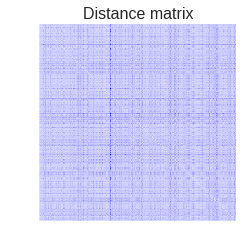

In [317]:
plt.figure(figsize=(12, 4))
pal = sns.light_palette("blue", as_cmap=True)

plt.subplot(131)
plt.imshow(dist[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("Distance matrix", fontdict={'fontsize': 16})

# plt.subplot(132)
# plt.imshow(P_constant[::10, ::10], interpolation='none', cmap=pal)
# plt.axis('off')
# plt.title("$p_{j|i}$ (constant $\sigma$)", fontdict={'fontsize': 16})

# plt.subplot(133)
# plt.imshow(P_binary_s[::10, ::10], interpolation='none', cmap=pal)
# plt.axis('off')
# plt.title("$p_{j|i}$ (variable $\sigma$)", fontdict={'fontsize': 16})
# plt.savefig('similarity-generated.png', dpi=120)

In [26]:
# import matplotlib.patheffects as PathEffects
def scatter(x, colors, n_colors = 10, centers=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", n_colors))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    if centers:
        txts = []
        for idxi,i in enumerate(centers):
            xtext, ytext = i[2],i[3]
            txt = ax.text(xtext, ytext, i[1].decode("utf-8"), fontsize=24)
            txts.append(txt)
            
        return f, ax, sc, txts

    return f, ax, sc#, txts

In [27]:
reload(sklearn.manifold.t_sne)

<module 'sklearn.manifold.t_sne' from '/usr/local/lib/python2.7/dist-packages/sklearn/manifold/t_sne.pyc'>

In [28]:
from sklearn.manifold.t_sne import TSNE
from sklearn.decomposition import PCA

In [29]:
np.shape(raw_val)

(70, 36, 35)

In [495]:
%%time
pca = PCA(n_components=50)
pca_proj = pca.fit_transform(raw_val)

CPU times: user 716 ms, sys: 0 ns, total: 716 ms
Wall time: 713 ms


In [491]:
# %%time
# dist = pairwise_distances(projection,metric=c2v_score,n_jobs=8) #np.correlate

CPU times: user 160 ms, sys: 92 ms, total: 252 ms
Wall time: 2.54 s


In [145]:
# outdated sklearn
# model = TSNE(n_components=3, perplexity=200.0, early_exaggeration=1.0,
#              learning_rate=500.0, n_iter=1000,
#              metric="precomputed",
#              init='random', verbose=1, random_state=1337)

In [52]:
from sklearn.decomposition import nmf

In [208]:
model = TSNE(n_components=2, perplexity=100.0, early_exaggeration=1.0, learning_rate=1000.0,
             n_iter=1000, n_iter_without_progress=50,
             min_grad_norm=1e-12, #1e-07,
             metric='precomputed',
             init='random',
             verbose=1, random_state=1337,
             method='barnes_hut',
             angle=0.5,
#              skip_early_exaggeration=False
            )

In [209]:
%%time
projection = model.fit_transform(dist) #raw_val

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2724
[t-SNE] Computed conditional probabilities for sample 2000 / 2724
[t-SNE] Computed conditional probabilities for sample 2724 / 2724
[t-SNE] Mean sigma: 0.006592
[t-SNE] Error after 100 iterations with early exaggeration: 0.888895
[t-SNE] Error after 125 iterations: 0.859893
CPU times: user 30.5 s, sys: 1.04 s, total: 31.5 s
Wall time: 31.5 s


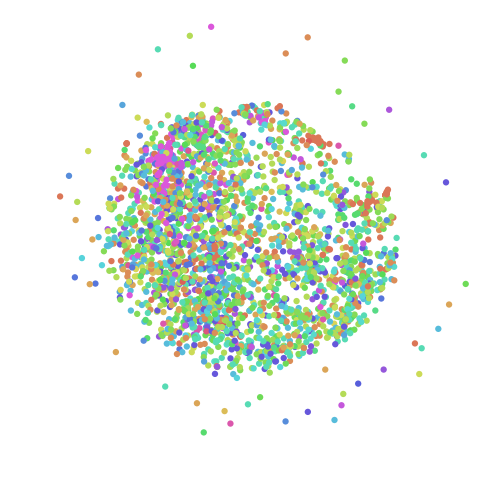

In [210]:
_ = scatter(projection,l,n_colors=34)

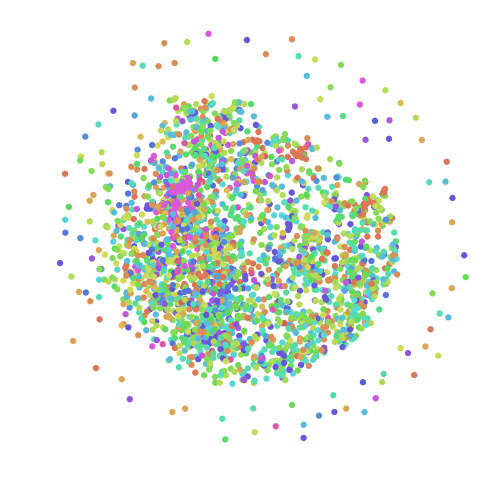

In [204]:
_ = scatter(projection,l,n_colors=34)

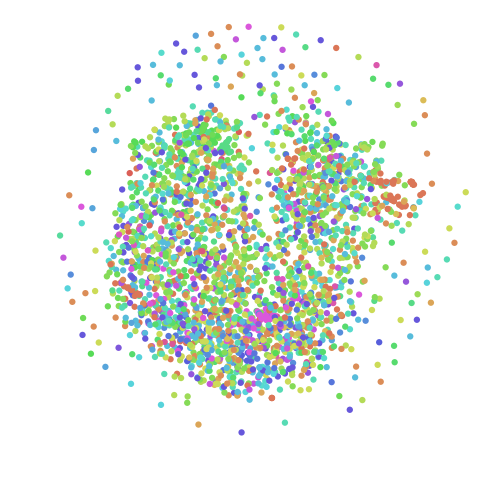

In [197]:
_ = scatter(projection2,l,n_colors=34)

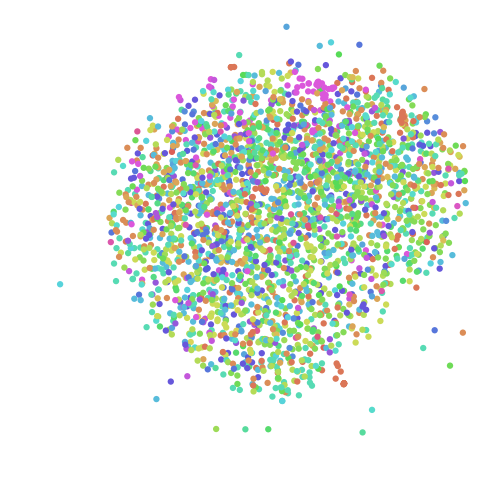

In [132]:
_ = scatter(projection3,l,n_colors=34)

In [195]:
# model = TSNE(n_components=2, perplexity=74.0, early_exaggeration=4.0, learning_rate=100.0,
#              n_iter=500, n_iter_without_progress=30,
#              min_grad_norm=1e-7, #1e-07,
#              metric='precomputed',
#              init=projection,
#              verbose=1, random_state=1337,
#              method='barnes_hut',
#              angle=0.5,
#              skip_early_exaggeration=False
#             )
# model = TSNE(n_components=2, perplexity=200.0, early_exaggeration=1.0, learning_rate=100.0,  #100.0
#              n_iter=1000, n_iter_without_progress=30,
#              min_grad_norm=1e-9, #1e-07,
#              metric='precomputed',
#              init=projection,
#              verbose=1, random_state=1337,
#              method='barnes_hut',
#              angle=0.5,
#              skip_early_exaggeration=False  #False
#             )
# model = TSNE(n_components=2, perplexity=200.0, early_exaggeration=1.0, learning_rate=100.0,  #100.0
#              n_iter=1000, n_iter_without_progress=30,
#              min_grad_norm=1e-9, #1e-07,
#              metric='precomputed',
#              init=projection,
#              verbose=1, random_state=1337,
#              method='barnes_hut',
#              angle=0.5,
#              skip_early_exaggeration=True  #False
#             )
model2 = TSNE(n_components=2, perplexity=5.0,
             early_exaggeration=None,  # 4.0
             learning_rate=50.0,  #100.0
             n_iter=1000, n_iter_without_progress=30,
             min_grad_norm=1e-7, #1e-07,
             metric='precomputed',
             init=projection,
             verbose=1, random_state=1337,
             method='barnes_hut',
             angle=0.5
            )

In [196]:
%%time
projection2 = model2.fit_transform(dist) #raw_val

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2724
[t-SNE] Computed conditional probabilities for sample 2000 / 2724
[t-SNE] Computed conditional probabilities for sample 2724 / 2724
[t-SNE] Mean sigma: 0.004673
[t-SNE] Error after 225 iterations: 2.525561
CPU times: user 18.3 s, sys: 1.36 s, total: 19.6 s
Wall time: 19.6 s


In [130]:
model = TSNE(n_components=2, perplexity=5.0, early_exaggeration=1.0, learning_rate=50.0,  #100.0
             n_iter=1000, n_iter_without_progress=30,
             min_grad_norm=1e-7, #1e-07,
             metric='precomputed',
             init=projection2,
             verbose=1, random_state=1337,
             method='barnes_hut',
             angle=0.5,
             skip_early_exaggeration=True  #False
            )

In [131]:
projection3 = model.fit_transform(dist) #raw_val

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2724
[t-SNE] Computed conditional probabilities for sample 2000 / 2724
[t-SNE] Computed conditional probabilities for sample 2724 / 2724
[t-SNE] Mean sigma: 0.004653
[t-SNE] Error after 225 iterations: 2.707996


In [ ]:
# projection = model.fit(all_dist[0]) #raw_val

---

---

---

In [54]:
import numpy as np
from scipy import linalg
import scipy.sparse as sp
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.neighbors import BallTree
from sklearn.base import BaseEstimator
from sklearn.utils import check_array
from sklearn.utils import check_random_state
from sklearn.utils.extmath import _ravel
from sklearn.decomposition import RandomizedPCA
from sklearn.metrics.pairwise import pairwise_distances
# from sklearn import _utils
# from sklearn import _barnes_hut_tsne
from sklearn.utils.fixes import astype

In [55]:
from sklearn.manifold.t_sne import *
from sklearn.manifold.t_sne import (_joint_probabilities, _joint_probabilities_nn, 
                                    _kl_divergence, _kl_divergence_error, _kl_divergence_bh,
                                   _gradient_descent)

In [175]:
def patched_init(self, n_components=2, perplexity=30.0,
                 early_exaggeration=4.0, learning_rate=1000.0, n_iter=1000,
                 n_iter_without_progress=30, min_grad_norm=1e-7,
                 metric="euclidean", init="random", verbose=0,
                 random_state=None, method='barnes_hut', angle=0.5 #,skip_early_exaggeration=False
            ):
    
    if not isinstance(init, np.ndarray) and init not in ["pca", "random"]:
        msg = "'init' must be 'pca', 'random' or a NumPy array"
        raise ValueError(msg)
        
    self.n_components = n_components
    self.perplexity = perplexity
    self.early_exaggeration = early_exaggeration
    self.learning_rate = learning_rate
    self.n_iter = n_iter
    self.n_iter_without_progress = n_iter_without_progress
    self.min_grad_norm = min_grad_norm
    self.metric = metric
    self.init = init
    self.verbose = verbose
    self.random_state = random_state
    self.method = method
    self.angle = angle
    self.embedding_ = None
    self.skip_early_exaggeration = False if early_exaggeration else True

In [176]:
def patched_tsne(self, P, degrees_of_freedom, n_samples, random_state,
                 skip_early_exaggeration,
                 X_embedded=None, neighbors=None, skip_num_points=0):
    """Runs t-SNE."""
    # t-SNE minimizes the Kullback-Leiber divergence of the Gaussians P
    # and the Student's t-distributions Q. The optimization algorithm that
    # we use is batch gradient descent with three stages:
    # * early exaggeration with momentum 0.5
    # * early exaggeration with momentum 0.8
    # * final optimization with momentum 0.8
    # The embedding is initialized with iid samples from Gaussians with
    # standard deviation 1e-4.

    if X_embedded is None:
        # Initialize embedding randomly
        X_embedded = 1e-4 * random_state.randn(n_samples,
                                               self.n_components)
    params = X_embedded.ravel()

    opt_args = {}
    opt_args = {"n_iter": 50, "momentum": 0.5, "it": 0,
                "learning_rate": self.learning_rate,
                "verbose": self.verbose, "n_iter_check": 25,
                "kwargs": dict(skip_num_points=skip_num_points)}
    if self.method == 'barnes_hut':
        m = "Must provide an array of neighbors to use Barnes-Hut"
        assert neighbors is not None, m
        obj_func = _kl_divergence_bh
        objective_error = _kl_divergence_error
        sP = squareform(P).astype(np.float32)
        neighbors = neighbors.astype(np.int64)
        args = [sP, neighbors, degrees_of_freedom, n_samples,
                self.n_components]
        opt_args['args'] = args
        opt_args['min_grad_norm'] = 1e-3
        opt_args['n_iter_without_progress'] = 30
        # Don't always calculate the cost since that calculation
        # can be nearly as expensive as the gradient
        opt_args['objective_error'] = objective_error
        opt_args['kwargs']['angle'] = self.angle
        opt_args['kwargs']['verbose'] = self.verbose
    else:
        obj_func = _kl_divergence
        opt_args['args'] = [P, degrees_of_freedom, n_samples,
                            self.n_components]
        opt_args['min_error_diff'] = 0.0
        opt_args['min_grad_norm'] = 0.0

    # Early exaggeration
    if not self.skip_early_exaggeration:
        P *= self.early_exaggeration
        
        params, error, it = _gradient_descent(obj_func, params, **opt_args)

    if not self.skip_early_exaggeration:
        opt_args['n_iter'] = 100
        opt_args['momentum'] = 0.8
        opt_args['it'] = it + 1
        params, error, it = _gradient_descent(obj_func, params, **opt_args)
        if self.verbose:
            print("[t-SNE] Error after %d iterations with early "
                  "exaggeration: %f" % (it + 1, error))
        # Save the final number of iterations
        self.n_iter_final = it

    # Final optimization
    if not self.skip_early_exaggeration:
        P /= self.early_exaggeration
    else: ### ???
        it = 0
    opt_args['n_iter'] = self.n_iter
    opt_args['momentum'] = 0.8
    opt_args['it'] = it + 1
    params, error, it = _gradient_descent(obj_func, params, **opt_args)
    if self.verbose:
        print("[t-SNE] Error after %d iterations: %f" % (it + 1, error))
        
    X_embedded = params.reshape(n_samples, self.n_components)

    return X_embedded

In [181]:
def patched__fit(self, X, skip_num_points=0):
    """Fit the model using X as training data.
    Note that sparse arrays can only be handled by method='exact'.
    It is recommended that you convert your sparse array to dense
    (e.g. `X.toarray()`) if it fits in memory, or otherwise using a
    dimensionality reduction technique (e.g. TrucnatedSVD).
    Parameters
    ----------
    X : array, shape (n_samples, n_features) or (n_samples, n_samples)
        If the metric is 'precomputed' X must be a square distance
        matrix. Otherwise it contains a sample per row. Note that this
        when method='barnes_hut', X cannot be a sparse array and if need be
        will be converted to a 32 bit float array. Method='exact' allows
        sparse arrays and 64bit floating point inputs.
    skip_num_points : int (optional, default:0)
        This does not compute the gradient for points with indices below
        `skip_num_points`. This is useful when computing transforms of new
        data where you'd like to keep the old data fixed.
    """
    if self.method not in ['barnes_hut', 'exact']:
        raise ValueError("'method' must be 'barnes_hut' or 'exact'")
    if self.angle < 0.0 or self.angle > 1.0:
        raise ValueError("'angle' must be between 0.0 - 1.0")
    if self.method == 'barnes_hut' and sp.issparse(X):
        raise TypeError('A sparse matrix was passed, but dense '
                        'data is required for method="barnes_hut". Use '
                        'X.toarray() to convert to a dense numpy array if '
                        'the array is small enough for it to fit in '
                        'memory. Otherwise consider dimensionality '
                        'reduction techniques (e.g. TruncatedSVD)')
        X = check_array(X, dtype=np.float32)
    else:
        X = check_array(X, accept_sparse=['csr', 'csc', 'coo'], dtype=np.float64)
    random_state = check_random_state(self.random_state)

    if not self.skip_early_exaggeration and self.early_exaggeration < 1.0:
        raise ValueError("early_exaggeration must be at least 1, but is "
                         "%f" % self.early_exaggeration)

    if self.n_iter < 200:
        raise ValueError("n_iter should be at least 200")

    if self.metric == "precomputed":
        if not isinstance(self.init, np.ndarray) and self.init == 'pca':
            raise ValueError("The parameter init=\"pca\" cannot be used "
                             "with metric=\"precomputed\".")
        if X.shape[0] != X.shape[1]:
            raise ValueError("X should be a square distance matrix")
        distances = X
    else:
        if self.verbose:
            print("[t-SNE] Computing pairwise distances...")
        if self.metric == "euclidean":
            distances = pairwise_distances(X, metric=self.metric,
                                           squared=True)
        else:
            distances = pairwise_distances(X, metric=self.metric)

    if not np.all(distances >= 0):
        raise ValueError("All distances should be positive, either "
                         "the metric or precomputed distances given "
                         "as X are not correct")

    # Degrees of freedom of the Student's t-distribution. The suggestion
    # degrees_of_freedom = n_components - 1 comes from
    # "Learning a Parametric Embedding by Preserving Local Structure"
    # Laurens van der Maaten, 2009.
    degrees_of_freedom = max(self.n_components - 1.0, 1)
    n_samples = X.shape[0]
    # the number of nearest neighbors to find
    k = min(n_samples - 1, int(3. * self.perplexity + 1))

    neighbors_nn = None
    if self.method == 'barnes_hut':
        if self.verbose:
            print("[t-SNE] Computing %i nearest neighbors..." % k)
        if self.metric == 'precomputed':
            # Use the precomputed distances to find
            # the k nearest neighbors and their distances
            neighbors_nn = np.argsort(distances, axis=1)[:, :k]
        else:
            # Find the nearest neighbors for every point
            bt = BallTree(X)
            # LvdM uses 3 * perplexity as the number of neighbors
            # And we add one to not count the data point itself
            # In the event that we have very small # of points
            # set the neighbors to n - 1
            distances_nn, neighbors_nn = bt.query(X, k=k + 1)
            neighbors_nn = neighbors_nn[:, 1:]
        P = _joint_probabilities_nn(distances, neighbors_nn,
                                    self.perplexity, self.verbose)
    else:
        P = _joint_probabilities(distances, self.perplexity, self.verbose)
    assert np.all(np.isfinite(P)), "All probabilities should be finite"
    assert np.all(P >= 0), "All probabilities should be zero or positive"
    assert np.all(P <= 1), ("All probabilities should be less "
                            "or then equal to one")
    
    if isinstance(self.init, np.ndarray):
        X_embedded = self.init
    elif self.init == 'pca':
        pca = RandomizedPCA(n_components=self.n_components,
                            random_state=random_state)
        X_embedded = pca.fit_transform(X)
    elif self.init == 'random':
        X_embedded = None
    else:
        raise ValueError("Unsupported initialization scheme: %s"
                         % self.init)

    return self._tsne(P, degrees_of_freedom, n_samples, random_state,
                      X_embedded=X_embedded,
                      neighbors=neighbors_nn,
                      skip_num_points=skip_num_points,
                      skip_early_exaggeration=self.skip_early_exaggeration
                     )

In [182]:
# Monkey patch this
TSNE.__init__ = patched_init
TSNE._tsne = patched_tsne
TSNE._fit = patched__fit
# TSNE.fit = patched_fit
# TSNE.fit_transform = patched_fit_transform

In [307]:
model = TSNE(n_components=2, perplexity=74.0, early_exaggeration=4.0, learning_rate=1000.0,
             n_iter=1000, n_iter_without_progress=30,
             min_grad_norm=1e-7, #1e-07,
             metric='precomputed',
             init=projection, #projection
             verbose=1, random_state=1337,
             method='barnes_hut',
             angle=0.5,
             skip_early_exaggeration=True
            )

In [308]:
%%time
projection2 = model.fit_transform(dist)

[t-SNE] Computing 223 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2724
[t-SNE] Computed conditional probabilities for sample 2000 / 2724
[t-SNE] Computed conditional probabilities for sample 2724 / 2724
[t-SNE] Mean sigma: 0.006204
[t-SNE] Error after 275 iterations: 1.221618
CPU times: user 51.2 s, sys: 8.05 s, total: 59.3 s
Wall time: 59.3 s


In [288]:
model.fit(dist[:10,:10])

[t-SNE] Computing 9 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Error after 75 iterations: 0.421000


In [289]:
projection2

array([[ 108.4368682 ,  -59.30729468],
       [-295.4483561 , -111.05839295],
       [ -54.24798797,   99.00710778],
       [ -78.63884211, -213.74006552],
       [ 158.99793324,  137.13589664],
       [ -44.94967287,  -63.71531548],
       [  20.40379786,  295.6043722 ],
       [ 281.90923729,  -77.2734351 ],
       [-157.90403108,  228.52375112],
       [ 146.8192512 , -218.358341  ]])

In [198]:
%%time
projection2 = model.fit_transform(dist) #raw_val

[t-SNE] Computing 223 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2724
[t-SNE] Computed conditional probabilities for sample 2000 / 2724
[t-SNE] Computed conditional probabilities for sample 2724 / 2724
[t-SNE] Mean sigma: 0.006204
[t-SNE] Error after 100 iterations with early exaggeration: 1.140348
[t-SNE] Error after 425 iterations: 1.061941
CPU times: user 1min 18s, sys: 9.17 s, total: 1min 28s
Wall time: 1min 27s


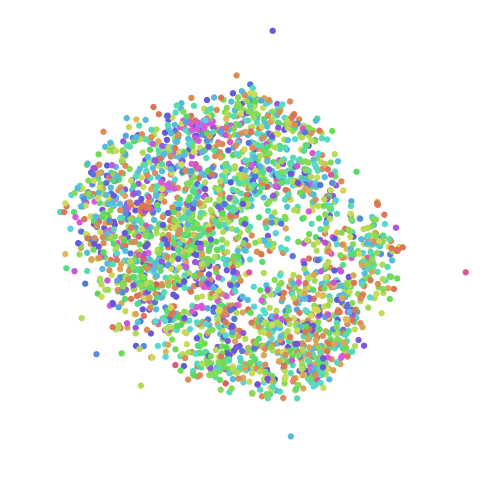

In [200]:
_ = scatter(projection,l,n_colors=34)

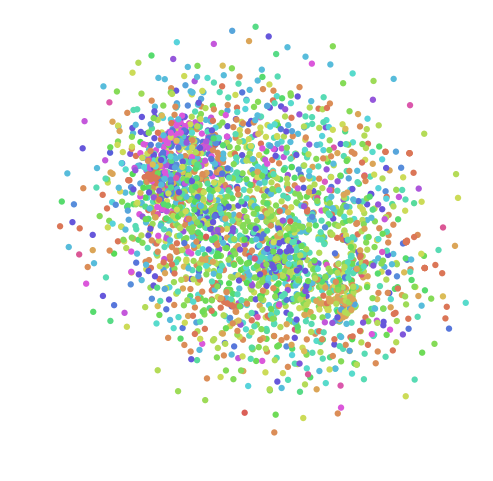

In [199]:
_ = scatter(projection2,l,n_colors=34)

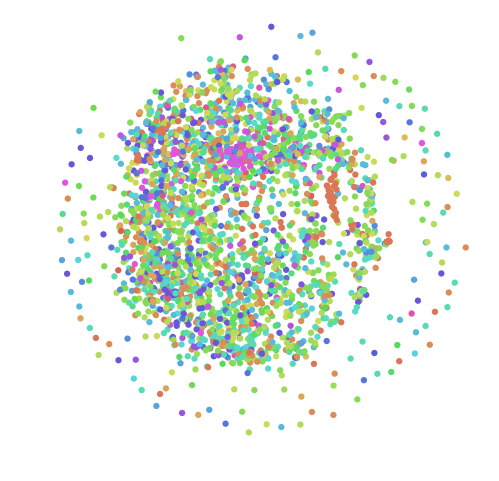

In [83]:
_ = scatter(projection,l,n_colors=34)

---

# Self organizing maps  

Trying this implem: ~~https://github.com/sevamoo/SOMPY~~ BAD!  
Tryed other bad ones, found this: https://github.com/peterwittek/somoclu, good so far

---

_Notes :_  
* "BMUs" likely means **Best-Matching Units**
* U-matrix: A U-matrix is a visual representation of the distances between neurons in the input data dimension space. Namely you calculate the distance between adjacent neurons, using their trained vector.
   [link](http://stackoverflow.com/questions/13631673/how-do-i-make-a-u-matrix)

In [22]:
#!pip install somoclu

In [23]:
import somoclu
from mpl_toolkits.mplot3d import Axes3D
import copy

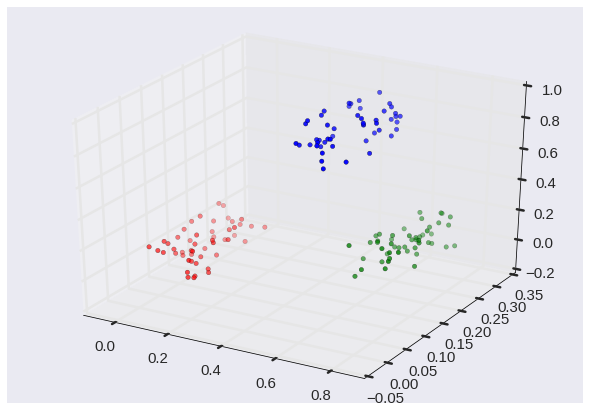

In [14]:
c1 = np.random.rand(50, 3)/5
c2 = (0.6, 0.1, 0.05) + np.random.rand(50, 3)/5
c3 = (0.4, 0.1, 0.7) + np.random.rand(50, 3)/5
data = np.float32(np.concatenate((c1, c2, c3)))
colors = ["red"] * 50
colors.extend(["green"] * 50)
colors.extend(["blue"] * 50)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors)
labels = range(150)

In [15]:
n_rows, n_columns = 100, 160
som = somoclu.Somoclu(n_columns, n_rows, data=data)
%time som.train()

CPU times: user 12.9 s, sys: 48 ms, total: 12.9 s
Wall time: 7.03 s


In [13]:
%%time
take_last = 40
period = "2015-10-01" # 2016-03-16  # 2016-04-15  # 2016-05-16

err0 = 0
err1 = 0
err2 = 0
err3 = 0

clean_symbols = []

min_len = len(eod.db[symbols[0]][period:])

for idxi,i in enumerate(symbols):
    if i in eod.db:
        v = eod.db[i][period:]["Close"]
        if not all(pd.isnull(v)): #and eod.db[i]["Volume"].mean()>20000:
            # 2016-04-15  # 2016-03-16  # 2016-05-16
#             v = eod.db[i][:"2016-05-16"][-take_last:]["Close"]#.fillna(method="backfill")#.values#.astype(int)
            if len(v) == min_len:
                if not any(pd.isnull(v)):
                    clean_symbols.append(i)
            else:
#                 print("0) Wrong length",idxi,i)
                err0 += 1
        else:
#             print("1) all NaN",idxi,i)
            err1 += 1
            
        if any(pd.isnull(v)):
#             print("2) some NaN",idxi,i)
            err2 += 1
    else:
#         print("__ 3) not eod.db",idxi,i)
        err3 += 1

CPU times: user 22.9 s, sys: 284 ms, total: 23.2 s
Wall time: 24.1 s


In [25]:
["Error {2}: {0:.{1}f}%".format(i,2,idx) for idx,i in enumerate(np.array([err0,err1,err2,err3])/float(len(symbols)) * 100)]

['Error 0: 1.84%', 'Error 1: 1.96%', 'Error 2: 21.36%', 'Error 3: 8.75%']

In [26]:
len(clean_symbols)

2724

In [321]:
def _center(x):
    c = (x - x.min())/(x.max() - x.min())
    return c.astype(np.float32)

def build_raw_val(period, take_last = 40):
    lab = []
    raw_val = []
    #2,3,4
    # 2016-03-16  # 2016-04-15  # 2016-05-16
    for idxi,i in enumerate(clean_symbols):
        if i in eod.db:
            if not any(pd.isnull(eod.db[i][:period][-take_last:]["Close"])): #and eod.db[i]["Volume"].mean()>20000:
                v = eod.db[i][:period][-take_last:]["Close"]#.fillna(method="backfill")#.values#.astype(int)
#             if not any(pd.isnull(eod.db[i][period:]["Close"])): #and eod.db[i]["Volume"].mean()>20000:
#                 v = eod.db[i][period:]["Close"]#.fillna(method="backfill")#.values#.astype(int)
                if len(v) == take_last:
                    raw_val.append(_center(v))
                    lab.append(i)
                else:
                    print(">> FAIL lvl 0 <<",idxi,i)
                    break
            else:
                print(">> FAIL lvl 1 <<",idxi,i)
                break
        else:
            print(">> FAIL lvl 2 <<",idxi,i)
            break
    return np.array(raw_val)

In [322]:
%%time
raw_val = build_raw_val("2016-01-15", take_last = 20)

CPU times: user 23.9 s, sys: 144 ms, total: 24.1 s
Wall time: 24.1 s


In [319]:
np.shape(raw_val)

(2779, 81)

In [330]:
big_raw = [] # 2,3,4
for i in ["2015-11-15","2016-01-15","2016-02-15","2016-03-15","2016-04-15","2016-05-15"]:
    big_raw.append(build_raw_val(i, take_last = 20))
big_raw = np.array(big_raw)

In [331]:
np.shape(big_raw)

(6, 2724, 20)

In [332]:
big_train = np.reshape(big_raw,(
        np.shape(big_raw)[0] * np.shape(big_raw)[1],
        np.shape(big_raw)[2],
    ))

In [333]:
np.shape(big_train)

(16344, 20)

In [179]:
assert(len(clean_symbols) == np.shape(raw_val)[0])

In [343]:
n_rows, n_columns = 256, 256
som = somoclu.Somoclu(n_columns, n_rows, data=big_train, initialcodebook=None,
                      kerneltype=0,
                      maptype="toroid", # planar, toroid
                      gridtype="rectangular", # rectangular, hexagonal
                      compactsupport=False, neighborhood="gaussian",
                      initialization="random") # pca, random

In [ ]:
%%time
# som.update_data(raw_val)
som.train(epochs=1000, radius0=0, radiusN=1, radiuscooling="linear",
                scale0=0.1, scaleN=0.01, scalecooling="linear")

In [346]:
t = {}
for i in som.bmus:
    t["%d %d"%(i[0],i[1])] = 1
len(t.keys())

15766

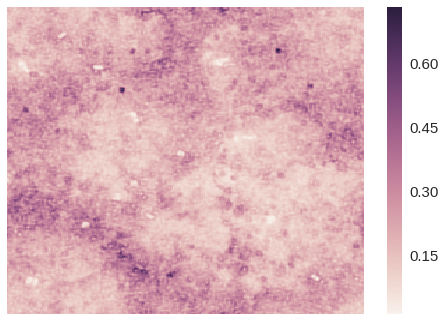

In [347]:
sns.heatmap(som.umatrix,xticklabels=False, yticklabels=False)
plt.plot()
_ = scatter(som.bmus,l,n_colors=34)
_ = plt.plot()

In [282]:
len(raw_val)

2779

In [ ]:
big_raw[ len(raw_val) * 0 : len(raw_val) * 1 ]

In [ ]:
%%time
som.update_data(big_raw[5])
som.train(epochs=1, radius0=0, radiusN=1, radiuscooling="linear",
                scale0=0.1, scaleN=0.01, scalecooling="linear")

In [ ]:
# results1 = copy.deepcopy(som.bmus)
# results2 = copy.deepcopy(som.bmus)
# results3 = copy.deepcopy(som.bmus)

In [354]:
_ = scatter(som.bmus,l,n_colors=34)
_ = plt.plot()

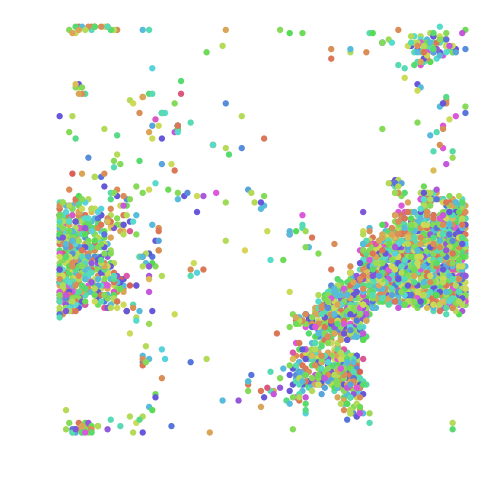

In [341]:
_ = scatter(som.bmus,l,n_colors=34)
_ = plt.plot()

In [304]:
_ = scatter(som.bmus,l,n_colors=34)
_ = plt.plot()

In [39]:
def get_loc_in_mat(vect):
    return min([np.array([i,j]) for i in range(len(som.codebook[0])) for j in range(len(som.codebook))],
                    key=lambda (x,y): np.linalg.norm(vect-som.codebook[y][x]))

In [59]:
flat_weightmat = np.reshape(som.codebook,
                            (np.shape(som.codebook)[0]*np.shape(som.codebook)[1],
                            np.shape(som.codebook)[2])
                           )

In [60]:
%%time
b = raw_val[0].dot(flat_weightmat.T)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 2.12 ms


In [62]:
np.linalg.norm(b)

3213.7373

In [40]:
rrr = np.reshape(np.repeat(raw_val[0],200,axis=0), (len(raw_val[0]),200)).T

In [55]:
np.argmin(np.linalg.norm(rrr - som.codebook, axis = 0))/200

ValueError: operands could not be broadcast together with shapes (40,200) (40,200,200) 

In [81]:
np.argmin(np.min(np.linalg.norm(rrr - som.codebook, axis = 1),axis=1))

61

In [52]:
np.argmin(np.linalg.norm(rrr - som.codebook, axis = 0))%200

7

In [240]:
np.shape(raw_val), np.shape(flat_weightmat)

((2711, 40), (40000, 40))

In [ ]:
np.subtract

In [239]:
#%%time
np.linalg.norm(raw_val[0]-som.codebook,axis=1)

(200, 40)

In [78]:
som.bmus[0]

array([169,  19], dtype=int32)

In [76]:
som.bmus[-1]

array([86, 25], dtype=int32)

In [233]:
np.argmax(b)/200, np.argmax(b)%200

(101, 27)

In [142]:
%%time
new_data = np.zeros((np.shape(som.bmus)))
for idxi,i in enumerate(raw_val[:10]):
    new_data[idxi] = get_loc_in_mat(i)
#     print(som.bmus[idxi], get_loc_in_mat(i))

CPU times: user 3.43 s, sys: 32 ms, total: 3.46 s
Wall time: 3.45 s


In [40]:
from joblib import Parallel, delayed

In [175]:
%%time
results = np.array(Parallel(n_jobs=8)(delayed(get_loc_in_mat)(i) for i in raw_val))

CPU times: user 420 ms, sys: 96 ms, total: 516 ms
Wall time: 4.37 s


In [300]:
for idxi,i in enumerate(raw_val[:10]):
    print(som.bmus[idxi], get_loc_in_mat(i))

[113  52] [101  87]
[107  66] [78 75]
[31 46] [118  40]
[21 31] [114  82]
[104  81] [47  7]
[ 59 102] [105  84]
[84 54] [106  83]
[ 86 113] [109  74]
[3 0] [117  37]
[113  99] [89 91]


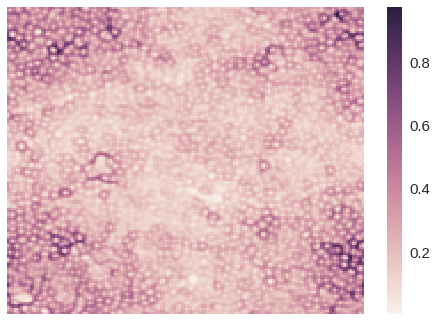

In [109]:
sns.heatmap(som.umatrix,xticklabels=False, yticklabels=False)

In [423]:
np.max(som.bmus[:,0]), np.max(som.bmus[:,1])

(255, 255)

In [119]:
#som.view_component_planes()

In [120]:
np.shape(som.bmus)

(2701, 2)

In [112]:
t = {}
for i in results:
    t["%d %d"%(i[0],i[1])] = 1
len(t.keys())

1227

In [251]:
som.bmus[:5],results[:5]

(array([[41, 54],
        [60,  9],
        [ 4, 19],
        [60, 31],
        [70,  8]], dtype=int32), array([[ 0, 20],
        [ 0, 20],
        [30,  0],
        [17,  2],
        [ 0, 21]]))

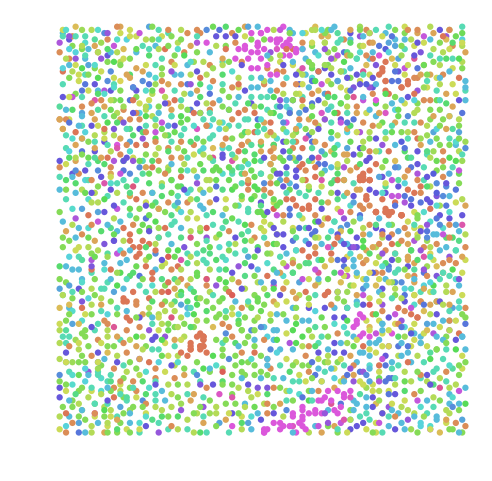

In [191]:
# t = som.bmus + np.random.rand(np.shape(som.bmus)[0],np.shape(som.bmus)[1])*10
_ = scatter(som.bmus,l,n_colors=34)

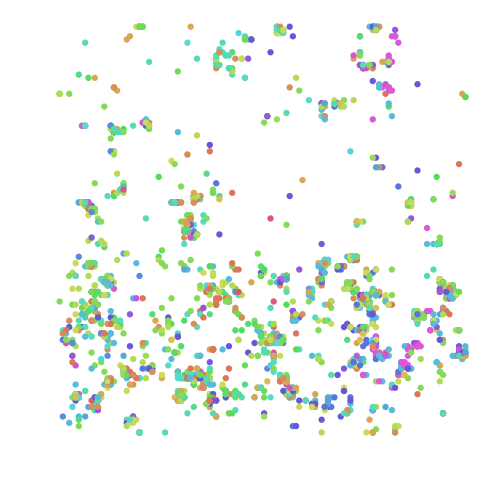

In [194]:
_ = scatter(som.bmus,l,n_colors=34)

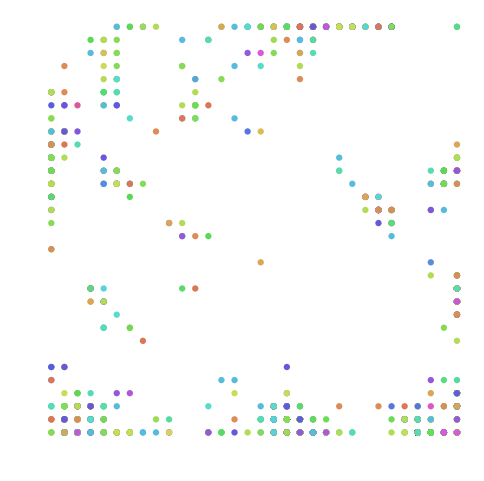

In [177]:
_ = scatter(results,l,n_colors=34)

In [189]:
#som.view_umatrix(bestmatches=True, labels=lab)

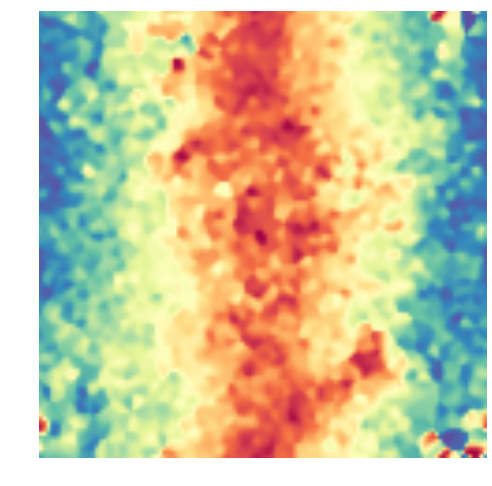

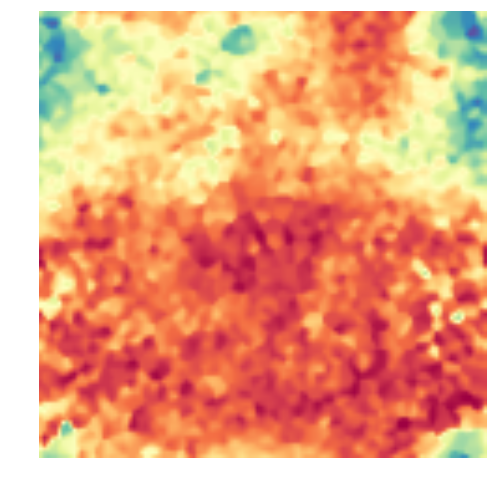

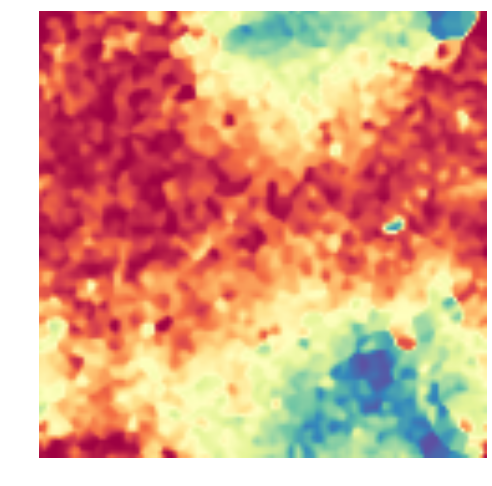

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

In [287]:
som.view_component_planes(dimensions=[0,10,39])

In [246]:
%%time
som.cluster()

CPU times: user 5.76 s, sys: 4 ms, total: 5.76 s
Wall time: 5.76 s


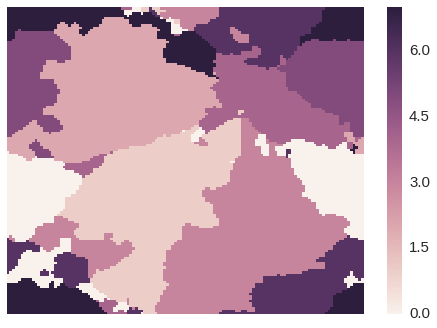

In [247]:
sns.heatmap(som.clusters,xticklabels=False, yticklabels=False)

In [38]:
#!pip install plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly as py

# takes ~3s
init_notebook_mode()

# qualitative coloscale
s = """rgb(198,60,80)
rgb(102,198,115)
rgb(143,60,150)
rgb(146,181,64)
rgb(84,87,186)
rgb(215,180,62)
rgb(111,129,234)
rgb(175,143,26)
rgb(71,41,121)
rgb(218,136,41)
rgb(100,148,223)
rgb(192,122,48)
rgb(180,122,220)
rgb(79,133,54)
rgb(216,103,190)
rgb(71,187,138)
rgb(174,51,105)
rgb(51,212,209)
rgb(213,74,74)
rgb(93,88,159)
rgb(202,175,85)
rgb(133,43,104)
rgb(148,155,71)
rgb(204,139,211)
rgb(128,99,31)
rgb(223,113,161)
rgb(214,147,90)
rgb(212,78,111)
rgb(198,89,49)
rgb(155,55,72)
rgb(213,119,94)
rgb(132,44,24)
rgb(220,110,112)"""
ss = s.split("\n")
colorscale = [[float(idxi)/(len(ss)-1),i] for idxi,i in enumerate(ss)]

In [73]:
trace = go.Scattergl(
    x = som.bmus[:,0],
    y = som.bmus[:,1],
    mode = 'markers',
    marker = dict(
        colorscale = colorscale,
#         color = pred,
        color = l,
        size=10,
    ),
    text = map(lambda x: x[0]+", "+_dic[x[1]],zip(lab,l)),
)

In [74]:
fig = go.Figure(data=[trace])#, layout=layout)
iplot(fig)
# !python -c "import plotly; plotly.tools.set_credentials_file(username='m3at', api_key='nbxztisjxm')"
# py.plotly.plot(fig,sharing='public')

---

In [263]:
from scipy.optimize import basinhopping

http://th.fhi-berlin.mpg.de/th/Meetings/DFT-workshop-Berlin2009/Talks/OnlinePublication/0626-1_20090626-1_Probert_2perA4_-_Probert_Matt.pdf

p6.)

Create initial population of trial solutions

Generations_loop: 

calculate fitness of each member of the population

select population members for crossover

perform crossover

mutate offspring

determine fitness of offspring

update the population

repeat until converged or sufficient generations

In [393]:
def saFunc(params):
    with Capturing() as output:
        model = TSNE(n_components=2,
                     perplexity=params[0]*5,
                     early_exaggeration=np.clip(params[1],1,99999),
                     learning_rate=1000.0,
                     n_iter=1000,
                     n_iter_without_progress=30,
                     min_grad_norm=1e-7, #1e-07,
                     metric='precomputed',
                     init='random',
                     verbose=1,
                     random_state=1337,
                     method='barnes_hut',
                     angle=0.5)
#                      angle=np.clip(params[2]/20,0.2,0.8))
        model.fit(dist)
    return float(output[-1].split(" ")[-1])

In [396]:
def sa_accept_test(f_new, x_new, f_old, x_old):
    return (x_new[0]>=1 and x_new[1]>=1 and x_old[1]>=1).tolist()

In [397]:
%%time
optimized = basinhopping(saFunc, [10,4], niter=100, T=1.0, stepsize=1, minimizer_kwargs=None,
             take_step=None, accept_test=sa_accept_test, callback=None,
             interval=5, disp=False, niter_success=None)
print("\n","*"*80)
print("Best:", optimized["x"]*[5,0.1])

optimized


 ********************************************************************************
Best: [ 74.57922431   2.24762796]
CPU times: user 1min 15s, sys: 4.26 s, total: 1min 20s
Wall time: 1min 20s


In [398]:
optimized

                        fun: 0.732169
 lowest_optimization_result:       fun: 0.732169
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 14.91584486,  22.47627962])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 404
                        nit: 100
                       njev: 101
                          x: array([ 14.91584486,  22.47627962])

In [253]:
def scorer(estimator, X, y):
    with Capturing() as output:
        projection = estimator.fit_transform(X)
    return float(output[-1].split(" ")[-1])

In [255]:
scorer(model,dist,_)

0.826405

In [259]:
sa = SimulatedAnneal(model, tsne_params, scoring=scorer, T=10, T_min=0.0001, alpha=0.75, n_trans=10,
                     max_iter=300, max_runtime=300, cv=0, verbose=False, refit=True,
                     n_jobs=1)

AssertionError: The provided estimator has no predict method

In [418]:
_ = scatter(projection,l,n_colors=34)

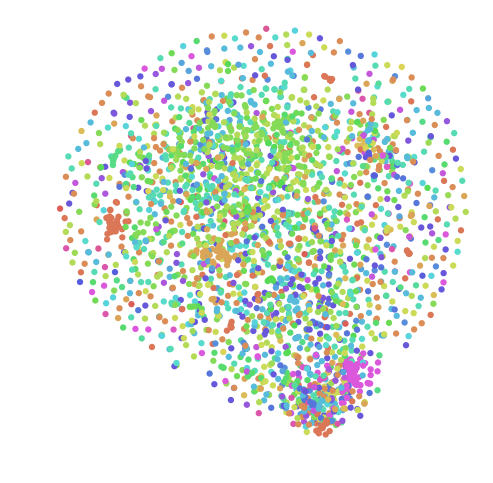

In [113]:
_ = scatter(projection,l,n_colors=34)

In [51]:
_ = scatter(projection,pred,n_colors=34)

In [430]:
projection[:5]

array([[ -6.20331234, -12.05834709],
       [ -9.95333009,  -5.91056986],
       [ -1.06878376,  -8.20861189],
       [ -6.22799592,   0.3984323 ],
       [ -9.88846352,  -5.91637469]])

In [162]:
np.shape(results[:2701])

(2701, 2)

In [161]:
np.shape(som.bmus)

(2701, 2)

In [159]:
results

array([[156,  78],
       [106,  22],
       [173,  30],
       ..., 
       [175, 109],
       [166,  92],
       [188, 100]])

In [172]:
len(l)

2702

In [155]:
# tmp_df = pd.DataFrame(data=som.bmus,columns=["x","y"])
tmp_df = pd.DataFrame(data=projection,columns=["x","y"])
tmp_df["sector number"] = l
tmp_df["Symbol"] = lab
tmp_df["sector"] = tmp_df.apply(lambda row: _dic[row["sector number"]],axis=1)
tmp_df.head()

x         y  sector number  Symbol sector
0  5.617839  9.176979              1  8966-T      -
1  2.276989  6.258980             13  9003-T    陸運業
2  1.880441  4.739984             18  6775-T   電気機器
3  8.025030  1.417511             15  3187-T    小売業
4 -0.793380  4.643133             13  9009-T    陸運業

In [156]:
# tmp_df.to_csv("/jupyter/data/stocks_by_sector.csv")

In [157]:
t = pd.DataFrame(data=tmp_df[["Symbol","x","y","sector number","sector"]])

In [158]:
merged = t.merge(JP_stocks,on="Symbol")

In [159]:
merged.head()

Symbol         x         y  sector number sector        日付  Company Name  \
0  8966-T  5.617839  9.176979              1      -  20160428  平和不動産リート投資法人   
1  9003-T  2.276989  6.258980             13    陸運業  20160428    相鉄ホールディングス   
2  6775-T  1.880441  4.739984             18   電気機器  20160428        ＴＢグループ   
3  3187-T  8.025030  1.417511             15    小売業  20160428      サンワカンパニー   
4  9009-T -0.793380  4.643133             13    陸運業  20160428          京成電鉄   

                    市場・商品区分 33 types code 33業種区分 17 types code  17業種区分 規模コード  \
0  REIT・ベンチャーファンド・カントリーファンド             -      -             -       -     -   
1                市場第一部（内国株）          5050    陸運業            12  運輸・物流      4   
2                市場第二部（内国株）          3650   電気機器             9  電機・精密      -   
3                 マザーズ（内国株）          6100    小売業            14     小売      -   
4                市場第一部（内国株）          5050    陸運業            12  運輸・物流      4   

           規模区分  
0             -  
1  TOPIX Mid400  
2             -  
3             -  
4  TOPIX Mid400

In [160]:
_merged = merged.rename(columns={"Symbol":"stock","x":"x_axis","y":"y_axis",
                                 "sector number":"region","Company Name":"companyname",
                                 "17 types code":"17_types_code",
                                 "17業種区分":"17_industry_sector"
                                })[["stock",
                                    "x_axis",
                                    "y_axis",
                                    "region",
                                    "sector",
                                    "companyname",
                                    "17_types_code",
                                    "17_industry_sector"
                                   ]]
_merged.head()

stock    x_axis    y_axis  region sector   companyname 17_types_code  \
0  8966-T  5.617839  9.176979       1      -  平和不動産リート投資法人             -   
1  9003-T  2.276989  6.258980      13    陸運業    相鉄ホールディングス            12   
2  6775-T  1.880441  4.739984      18   電気機器        ＴＢグループ             9   
3  3187-T  8.025030  1.417511      15    小売業      サンワカンパニー            14   
4  9009-T -0.793380  4.643133      13    陸運業          京成電鉄            12   

  17_industry_sector  
0                  -  
1             運輸・物流   
2             電機・精密   
3                小売   
4             運輸・物流

In [161]:
_merged.to_csv("/jupyter/data/data.csv")
# _merged.to_csv("/jupyter/data/mod.csv")
# _merged.to_csv("/jupyter/data/mod2.csv")

In [101]:
_modified = _merged.copy()

In [102]:
_modified["new_x_axis"] = _merged["x_axis"].apply(lambda x:int(x+np.random.rand()*20))
_modified["new_y_axis"] = _merged["y_axis"].apply(lambda x:int(x+np.random.rand()*10))

In [103]:
_modified.head()

stock  x_axis  y_axis  region sector   companyname 17_types_code  \
0  8966-T     109      56       1      -  平和不動産リート投資法人             -   
1  9003-T      42      16      13    陸運業    相鉄ホールディングス            12   
2  6775-T     173     182      18   電気機器        ＴＢグループ             9   
3  3187-T      76     155      15    小売業      サンワカンパニー            14   
4  9009-T      40      19      13    陸運業          京成電鉄            12   

  17_industry_sector  new_x_axis  new_y_axis  
0                  -         114          60  
1             運輸・物流           47          17  
2             電機・精密          192         183  
3                小売           87         161  
4             運輸・物流           45          22

In [104]:
_modified.to_csv("/jupyter/data/mod.csv")

In [349]:
ttt = []
for i in t["stock"]:
    try:
        ttt.append(JP_stocks[JP_stocks["Symbol"] == i]["Company Name"].values[0])
    except IndexError:
        ttt.append("UNK")

In [331]:
len(ttt)

2725

In [350]:
t = t.rename(columns={"symbol":"stock","x":"x_axis","y":"y_axis","sector number":"region"})
t.head()

stock    x_axis    y_axis  region sector  company name
0  8966-T -2.778294 -9.645575       1      -  平和不動産リート投資法人
1  9003-T  8.326282 -2.710723      13    陸運業    相鉄ホールディングス
2  6775-T  0.003788  0.182753      18   電気機器        ＴＢグループ
3  3187-T -5.979854  1.151972      15    小売業      サンワカンパニー
4  9009-T  8.361583 -2.446680      13    陸運業          京成電鉄

In [351]:
t["company name"] = ttt
t.head()

stock    x_axis    y_axis  region sector  company name
0  8966-T -2.778294 -9.645575       1      -  平和不動産リート投資法人
1  9003-T  8.326282 -2.710723      13    陸運業    相鉄ホールディングス
2  6775-T  0.003788  0.182753      18   電気機器        ＴＢグループ
3  3187-T -5.979854  1.151972      15    小売業      サンワカンパニー
4  9009-T  8.361583 -2.446680      13    陸運業          京成電鉄

In [352]:
t.to_csv("/jupyter/data/data.csv")

In [101]:
print(_dic[33].decode("utf-8"))

電気・ガス業


In [191]:
t = tmp_df.loc[tmp_df["sector number"] == 1][["x","y"]]
t.head()

x          y
0   -2.778294  -9.645575
48  19.743152 -11.771223
49  -9.945814   3.243011
63   7.230223  -2.585162
74  17.727633 -10.037310

In [192]:
tmp_df.loc[tmp_df["sector number"] == 12][["x","y"]].values.mean(axis=0)

array([ 7.26103872, -5.73844223])

In [198]:
centers = []
for i in _dic.keys():
    v = tmp_df.loc[tmp_df["sector number"] == i][["x","y"]].values.mean(axis=0)
    if not any(np.isnan(v)):
        centers.append([i,_dic[i],v[0],v[1]])
    else:
        centers.append([i,_dic[i],0,0])

In [199]:
centers_df = pd.DataFrame(data=centers,columns=["sector number","sector","x","y"])
centers_df.head()

sector number  sector         x         y
0              0  水産・農林業  9.857706 -0.982593
1              1       -  5.546413 -4.975319
2              2     卸売業  6.898016 -3.758686
3              3     建設業  3.728764  2.679986
4              4    非鉄金属  8.790592 -6.472843

In [201]:
centers_df.to_csv("/jupyter/data/centers_by_sector.csv")

In [278]:
print(JP_stocks.loc[JP_stocks["Symbol"] == "1301-T"]["Company Name"].values[0].decode("utf-8"))

極洋


In [39]:
# http://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NASDAQ&render=download
# US_stocks = pd.read_csv("/jupyter/data/companylist.csv")
# US_stocks.head()
JP_stocks = pd.read_csv("/jupyter/data/JP Stocks Sector info.csv")

JP_stocks["Symbol"] = JP_stocks.apply(lambda x: str(x[1])+"-T",axis=1)
JP_stocks.head()

日付  Symbol          Company Name     市場・商品区分 33 types code  33業種区分  \
0  20160428  1301-T                    極洋  市場第一部（内国株）            50  水産・農林業   
1  20160428  1305-T         ダイワ上場投信－トピックス     ETF・ETN             -       -   
2  20160428  1306-T        ＴＯＰＩＸ連動型上場投資信託     ETF・ETN             -       -   
3  20160428  1308-T     上場インデックスファンドＴＯＰＩＸ     ETF・ETN             -       -   
4  20160428  1309-T  上海株式指数・上証５０連動型上場投資信託     ETF・ETN             -       -   

  17 types code 17業種区分 規模コード           規模区分  
0             1    食品      6  TOPIX Small 1  
1             -      -     -              -  
2             -      -     -              -  
3             -      -     -              -  
4             -      -     -              -

In [40]:
dic = {}
c = 0
for s in JP_stocks["33業種区分"]: #33業種区分  33 types code
    try:
        dic[s]
    except KeyError:
        dic[s] = c
        c+=1
len(dic.keys())

34

In [41]:
_dic = {}
for i in dic:
    _dic[dic[i]] = i

In [45]:
l = []
for idxi,i in enumerate(lab):
    try:
        l.append(dic[
                JP_stocks.loc[JP_stocks["Symbol"] == i]["33業種区分"].values[0]
                ])
    except IndexError:
        l.append(1)
l = np.array(l)

In [127]:
projection[:10]

NameError: name 'projection' is not defined

In [ ]:
pd.DataFrame

(<matplotlib.figure.Figure at 0x7fbb72ee8a50>,
 <matplotlib.collections.PathCollection at 0x7fbb72a34a50>)

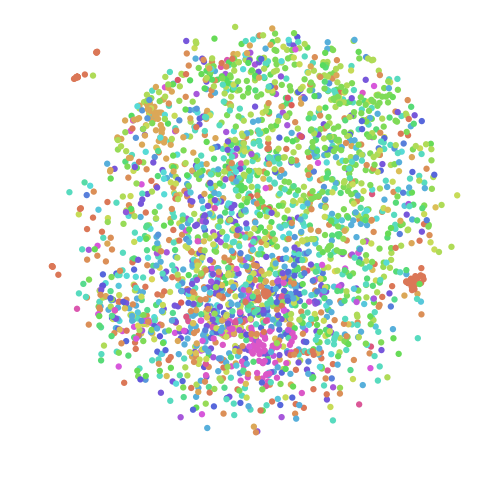

In [177]:
scatter(projection,l,n_colors=33)

In [ ]:
#!pip install plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly as py

# takes ~3s
init_notebook_mode()

# qualitative coloscale
s = """rgb(198,60,80)
rgb(102,198,115)
rgb(143,60,150)
rgb(146,181,64)
rgb(84,87,186)
rgb(215,180,62)
rgb(111,129,234)
rgb(175,143,26)
rgb(71,41,121)
rgb(218,136,41)
rgb(100,148,223)
rgb(192,122,48)
rgb(180,122,220)
rgb(79,133,54)
rgb(216,103,190)
rgb(71,187,138)
rgb(174,51,105)
rgb(51,212,209)
rgb(213,74,74)
rgb(93,88,159)
rgb(202,175,85)
rgb(133,43,104)
rgb(148,155,71)
rgb(204,139,211)
rgb(128,99,31)
rgb(223,113,161)
rgb(214,147,90)
rgb(212,78,111)
rgb(198,89,49)
rgb(155,55,72)
rgb(213,119,94)
rgb(132,44,24)
rgb(220,110,112)"""
ss = s.split("\n")
colorscale = [[float(idxi)/(len(ss)-1),i] for idxi,i in enumerate(ss)]

In [ ]:
trace = go.Scattergl(
    x = projection[:,0],
    y = projection[:,1],
    mode = 'markers',
    marker = dict(
        colorscale = colorscale,
#         color = pred,
        color = l,
        size=8,
    ),
    text = map(lambda x: x[0]+", "+_dic[x[1]],zip(lab,l)),
)

In [427]:
fig = go.Figure(data=[trace])#, layout=layout)
iplot(fig)
# !python -c "import plotly; plotly.tools.set_credentials_file(username='m3at', api_key='nbxztisjxm')"
# py.plotly.plot(fig,sharing='public')

In [104]:
subset = []
for i in projection:
    if np.random.rand() < 0.1:
        subset.append(i)
subset = np.array(subset)
len(subset)

272

In [106]:
trace = go.Scatter3d(
    x = subset[:,0],
    y = subset[:,1],
    z = subset[:,2],
    mode = 'markers',
    marker = dict(
        colorscale = colorscale,
#         color = pred,
        color = l,
#         line = dict(width = 1),
#         opacity = 0.8
    ),
    text = map(lambda x: x[0]+", "+_dic[x[1]],zip(lab,l)),
)

In [107]:
fig = go.Figure(data=[trace])#, layout=layout)
iplot(fig)

In [233]:
dbscan = DBSCAN(eps=0.3, min_samples=10, metric='euclidean',
                algorithm='auto', leaf_size=30, p=None)

In [234]:
pred = dbscan.fit_predict(raw_val)

In [17]:
len(bigvec)

881

In [19]:
len(bigvec[0])

2

In [69]:
import pickle

In [65]:
len(bigvec[0])

3628

In [61]:
bigvec

[['8966-T',
  ('8966-T',
   1.0,
   Timestamp('2016-05-11 00:00:00'),
   Timestamp('2016-05-16 00:00:00'),
   0.0,
   335000.0,
   446666.66666666663,
   1.0),
  ('9003-T',
   0.8074074074074075,
   Timestamp('2016-05-11 00:00:00'),
   Timestamp('2016-05-16 00:00:00'),
   2534.7609354730084,
   1960111092.6875,
   3900.0,
   0.88989467375156195),
  ('3223-T',
   0.3851851851851852,
   Timestamp('2016-05-11 00:00:00'),
   Timestamp('2016-05-16 00:00:00'),
   nan,
   nan,
   nan,
   nan)],
 ['3223-T',
  ('3223-T',
   1.0,
   Timestamp('2016-05-11 00:00:00'),
   Timestamp('2016-05-16 00:00:00'),
   nan,
   nan,
   nan,
   nan),
  ('8966-T',
   0.7428571428571429,
   Timestamp('2016-05-11 00:00:00'),
   Timestamp('2016-05-16 00:00:00'),
   nan,
   nan,
   nan,
   nan),
  ('9003-T',
   0.6857142857142857,
   Timestamp('2016-05-11 00:00:00'),
   Timestamp('2016-05-16 00:00:00'),
   nan,
   nan,
   nan,
   nan)]]

In [36]:
ret[0]

('8966-T',
 0.8142857142857143,
 Timestamp('2016-05-11 00:00:00'),
 Timestamp('2016-05-16 00:00:00'),
 2536.1535836774556,
 1963345363.6875,
 33366.666666666664,
 0.90012817395443534)

In [20]:
dff = eod.db

In [21]:
dff["3187-T"].head()

Open  High  Low  Close  Volume
Date                                      
2015-05-08   678   678  665    675   20800
2015-05-11   685   697  674    680   59100
2015-05-12   679   689  671    688   94500
2015-05-13   688   693  670    678  103300
2015-05-14   687   687  647    650  114000

In [22]:
from matplotlib.finance import candlestick2_ohlc

start, end = ret[0][2] , ret[0][3]
x = dff[ret[0][0]][start:end] # np.random.randn(1000)


fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

candlestick2_ohlc(ax, x["Open"], x["High"], x["Low"], x["Close"], width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

plt.show()

In [97]:
from scipy.spatial.distance import cosine, euclidean

In [23]:
all_vec = []
for idxi,i in enumerate(ret[:5]):
    try:
        start, end = i[2] , i[3]
        x = dff[i[0]][start:end] # np.random.randn(1000)
        x["Range"] = x.apply(candle_range, axis=1)
        all_vec.append(x)
    except KeyError:
        pass

In [25]:
ret[1]

('2152-T',
 0.9,
 Timestamp('2016-05-11 00:00:00'),
 Timestamp('2016-05-16 00:00:00'),
 28.792360097775937,
 64670.25,
 3158.333333333333,
 0.97988641782895436)

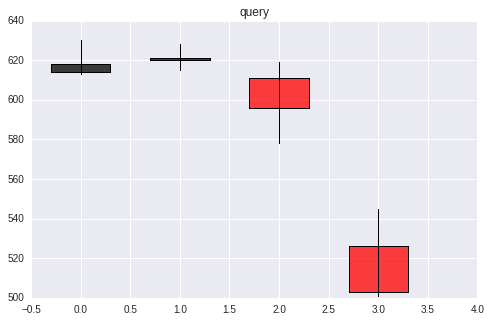

********************************************************************************
RESULTS
********************************************************************************


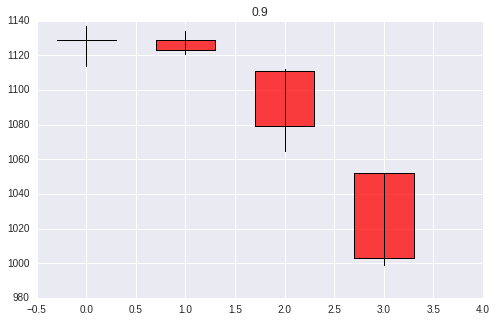

28.7923600978
64670.25
3158.33333333
0.979886417829


104.9142507
78130.9375
4156.0
0.954342014693


45.7165178026
3321.0
2870.33333333
0.852042604545


43.2087954009
1320.109375
634.166666667
0.956412571254


37.1079506306
41348.9375
2266.0
0.83755930035


1154.82249718
21069256.1875
25466.6666667
0.940311879988


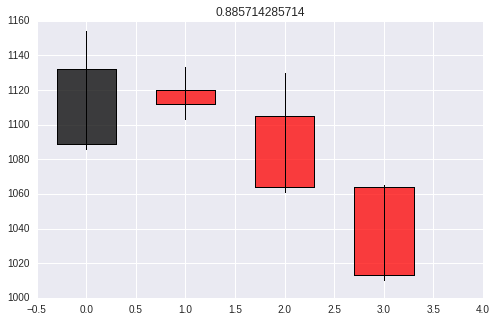

73.1778655059
63654.734375
2728.83333333
0.925782031039


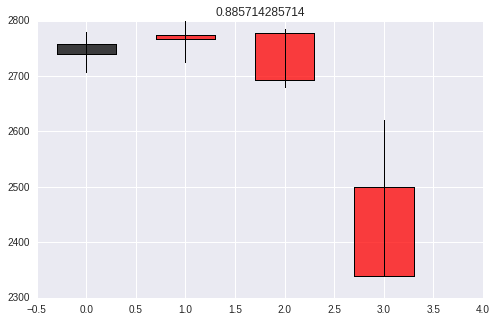

265.037733163
1071978.85938
11203.8333333
0.999202199045


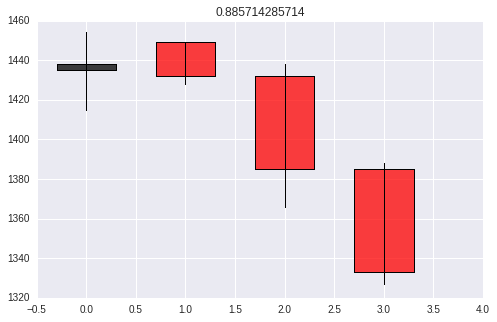

53.7587202229
167085.9375
2576.33333333
0.951731576108


In [26]:
start, end = ret[0][2] , ret[0][3]
x = dff[ret[0][0]][start:end] # np.random.randn(1000)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
candlestick2_ohlc(ax, x["Open"], x["High"], x["Low"], x["Close"], width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()
plt.title("query")
plt.show()

print("*"*80)
print("RESULTS")
print("*"*80)

for idxi,i in enumerate(ret[:10]): # sorted(ret[:10],key=lambda x: x[4])
    if idxi==0:
        continue
    try:
        start, end = i[2] , i[3]
        x = dff[i[0]][start:end] # np.random.randn(1000)
        fig, ax = plt.subplots()
        fig.subplots_adjust(bottom=0.2)
        candlestick2_ohlc(ax, x["Open"], x["High"], x["Low"],
                          x["Close"], width=0.6, colorup='k', colordown='r',
                          alpha=0.75)
        ax.autoscale_view()
        plt.title(i[1])
        plt.show()
        print(i[4])
        print(i[5])
        print(i[6])
        print(i[7])
    except KeyError:
        pass

# 1D Convolution
I simply adapt the kernel size, strides and padding, and input a 2D matrix with one of the dimension=1

In [6]:
import pickle
import numpy as np
from PIL import Image
import os
from StringIO import StringIO
import math
import pylab


import chainer
from chainer import computational_graph
from chainer import cuda
from chainer import optimizers
from chainer import serializers
from chainer import Variable
from chainer.utils import type_check
from chainer import function

import chainer.functions as F
import chainer.links as L


import numpy

In [7]:
nz = 128 #576
mist_val = 16 * 32 # 4 * 512 + 1 * 512
class CNN_1D(chainer.Chain):
    def __init__(self):
        super(CNN_1D, self).__init__(
            c0 = L.Convolution2D(1, 64, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*3)),
            c1 = L.Convolution2D(64, 128, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*64)),
            c2 = L.Convolution2D(128, 256, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*128)),
            c3 = L.Convolution2D(256, 512, (4, 1), stride=1, pad=0, wscale=1), #0.02*math.sqrt(4*4*256)),
            #
            # The problem with this fully connected layer is that it's
            # preventing the network to work on arbitrary sized inputs...
            # 
            # Max pooling used in a proper way could prevent this but
            # it's adding location invariance, we don't want that
            #
            l4l = L.Linear(mist_val, 1, wscale=0.02*math.sqrt(mist_val)), # 6*6*512
        )
        
    def __call__(self, x, test=False):
        h = F.relu(self.c0(x))
        h = F.relu(self.c1(h))
        h = F.relu(self.c2(h))
        h = F.relu(self.c3(h))
        l = self.l4l(h)
# #         mp0 = F.MaxPooling2D(4)
        return l

In [8]:
cnn = CNN_1D()

In [9]:
p = df[:100]["open"].values[:32]

In [10]:
ppp = np.reshape(p,(1,p.shape[0],1))

In [11]:
va = Variable(np.array([ppp.astype(np.float32)]))

In [12]:
ret = cnn(va)

In [13]:
ret.data

array([[ 0.00435226]], dtype=float32)

## Experiments with 1D CNN
Create a simple binary classification dataset

In [14]:
all_open = df["open"].values
len_samples = 32
size_dataset = 1000

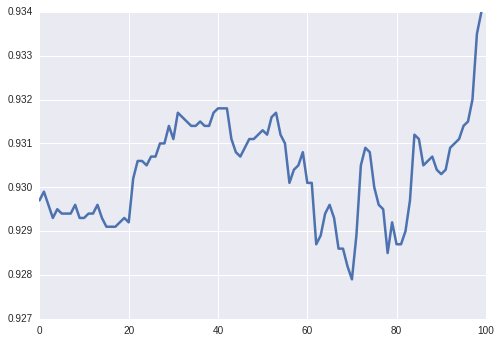

In [15]:
plt.plot(all_open[:100])
plt.show()

In [28]:
# normalisation functions
def norm(seq):
    return np.array(map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:])))

def norm_and_center(x,scale=1):
    c2 = norm(x)
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

def center(x):
    c = 2*(x - x.min())/(x.max() - x.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

In [17]:
fake_data = np.random.rand(size_dataset/2, len_samples).astype(np.float32)*2 - 1

real_data = np.empty((size_dataset/2, len_samples),dtype=np.float32)
for idxi,i in enumerate(real_data):
    rand = np.random.randint(0,len(all_open)-(len_samples))
    n = center(all_open[rand:rand+len_samples])
    real_data[idxi] = n

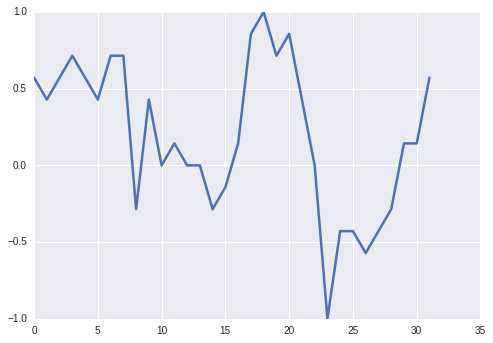

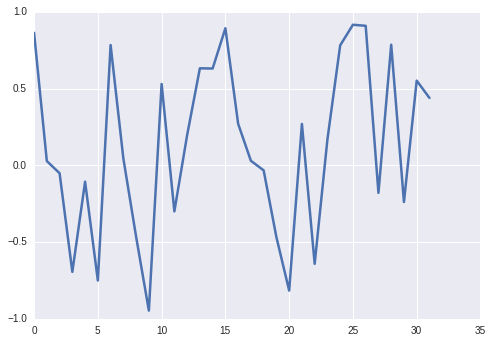

In [516]:
plt.plot(real_data[0])
plt.show()
plt.plot(fake_data[0])
plt.show()

In [18]:
data = zip(np.concatenate((fake_data,real_data)),
           np.concatenate((np.zeros(size_dataset/2).astype(np.int32) - 1,
                           np.ones(size_dataset/2).astype(np.int32)))
          )

In [19]:
data[0]

(array([ 0.27352238,  0.74014652, -0.7279439 ,  0.13564754, -0.59300184,
         0.77416122,  0.31624961, -0.12863523, -0.25189257,  0.7396996 ,
        -0.72045314,  0.87560582,  0.44058502,  0.56000888, -0.18242717,
         0.26759911, -0.40550655,  0.98328996,  0.07490718,  0.31689835,
        -0.06673956, -0.0263719 ,  0.9644928 , -0.60836726, -0.75130033,
         0.29169178, -0.48977178,  0.58678186,  0.11657119, -0.2240659 ,
        -0.58120501, -0.47157347], dtype=float32), -1)

In [20]:
ppp = np.reshape(data[0][0],(1,1,data[0][0].shape[0],1))

In [21]:
output = cnn(Variable(ppp))

In [22]:
output.data

array([[ 0.00191085]], dtype=float32)

In [23]:
class Train(chainer.Chain):
    def __init__(self, predictor):
        super(Train, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.sigmoid_cross_entropy(y, t) # softmax
        return self.loss

In [24]:
def eval_loss(eval_on=10):
    sum_loss = 0
    for i in range(0, eval_on):
        r_index = np.random.randint(len(data))
        _example,_label = data[r_index][0], data[r_index][1]
        example = Variable(np.reshape(_example,(1,1,_example.shape[0],1)))
        label = Variable(np.reshape(_label,(1,1)))
        loss = t_cnn( example,label )

        sum_loss += loss.data
    mean_loss = sum_loss / eval_on
    return mean_loss

In [25]:
cnn = CNN_1D()
t_cnn = Train(cnn)
optimizer = optimizers.Adam()
optimizer.setup(t_cnn)

In [26]:
#%%time
n_epoch = 100

for epoch in range(n_epoch):
    cnn.zerograds()
    
    r_index = np.random.randint(len(data))
    _example,_label = data[r_index][0], data[r_index][1]
    example = Variable(np.reshape(_example,(1,1,_example.shape[0],1)))
    label = Variable(np.reshape(_label,(1,1)))
#     t_cnn( Variable(ppp),Variable(np.reshape(label,(1,1)) ))
    
    optimizer.update(t_cnn,example,label)
    
    if epoch==0 or epoch%(n_epoch/20)==0 or epoch==n_epoch-1:
        print("%s: %0.9f" %(str(epoch).ljust(10),eval_loss()))

0         : 0.207490945
5         : 0.196202570
10        : 0.382884312
15        : 0.272359699
20        : 0.241174093
25        : 0.133280491
30        : 0.006006680
35        : 0.000066515
40        : 0.000000069
45        : 0.000000002
50        : 0.000000000
55        : 0.000000000
60        : 0.000000000
65        : 0.000000000
70        : 0.000000000
75        : 0.000000000
80        : 0.000000000
85        : 0.000000000
90        : 0.000000000
95        : 0.000000000
99        : 0.000000000


6.26358634016e-19 1 ok


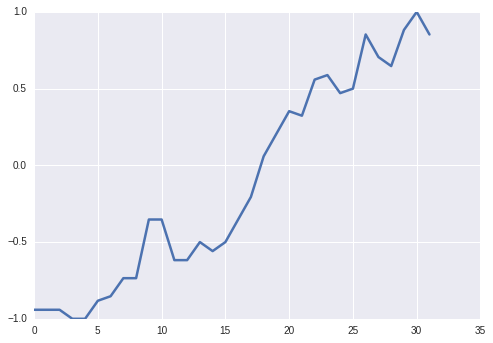

In [29]:
r_index = np.random.randint(len(data))
_example,_label = data[r_index][0], data[r_index][1]
example = Variable(np.reshape(_example,(1,1,_example.shape[0],1)))
label = Variable(np.reshape(_label,(1,1)))
loss = t_cnn( example,label )

print(loss.data,_label, "ok" if (loss.data>0 and _label==1) or (loss.data<=0 and _label==-1) else "FALSE")
plt.plot(_example)
plt.show()

In [30]:
print("Loss:",eval_loss(eval_on=1000))

Loss: 2.28441817157e-11


---

---

---

---

---

---

In [7]:
class Generator(chainer.Chain):
    def __init__(self):
        super(Generator, self).__init__(
            l0z = L.Linear(nz, mist_val, wscale=0.02*math.sqrt(nz)),
            dc1 = L.Deconvolution2D(nz, 256, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*512)),
            dc2 = L.Deconvolution2D(256, 128, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*256)),
            dc3 = L.Deconvolution2D(128, 64, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*128)),
            dc4 = L.Deconvolution2D(64, 3, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*64)),
        )
    def __call__(self, z, test=False):
        h = F.reshape(F.relu(self.l0z(z)), (z.data.shape[0], 128, 4, 1)) # 512, 6, 6))
        h = F.relu(self.dc1(h))
        h = F.relu(self.dc2(h))
        h = F.relu(self.dc3(h))
        x = (self.dc4(h))
        return x

class Discriminator(chainer.Chain):
    def __init__(self):
        super(Discriminator, self).__init__(
            c0 = L.Convolution2D(1, 64, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*3)),
            c1 = L.Convolution2D(64, 128, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*64)),
            c2 = L.Convolution2D(128, 256, (4, 1), stride=(2,1), pad=(1,0), wscale=0.02*math.sqrt(4*4*128)),
            c3 = L.Convolution2D(256, 512, (4, 1), stride=1, pad=0, wscale=1), #0.02*math.sqrt(4*4*256)),
            l4l = L.Linear(mist_val, 2, wscale=0.02*math.sqrt(mist_val)), # 6*6*512
        ) 
    def __call__(self, x, test=False):
        h = F.relu(self.c0(x))
        h = F.relu(self.c1(h))
        h = F.relu(self.c2(h))
        h = F.relu(self.c3(h))
        l = self.l4l(h)
        return l

In [256]:
g = Generator()

In [50]:
out = g(Variable(np.array([np.random.randn(nz).astype(np.float32)])))

NameError: name 'g' is not defined

In [259]:
out.data[0][0]

array([[-0.00132109],
       [-0.00762908],
       [-0.00277361],
       [-0.01768656],
       [ 0.0030693 ],
       [-0.01951565],
       [ 0.00167972],
       [-0.02423818],
       [ 0.00691997],
       [-0.01482223],
       [-0.01639871],
       [-0.01389591],
       [-0.01467269],
       [-0.03430352],
       [-0.01828811],
       [-0.01573746],
       [-0.01368324],
       [-0.02861563],
       [-0.00709159],
       [-0.04232799],
       [-0.02057808],
       [-0.01282598],
       [-0.01741303],
       [-0.03164081],
       [-0.02795931],
       [-0.01647522],
       [-0.01239936],
       [-0.03419115],
       [-0.00689191],
       [-0.02075935],
       [-0.00333366],
       [-0.03502258],
       [-0.020837  ],
       [-0.02870523],
       [-0.0280411 ],
       [-0.04126644],
       [ 0.00832296],
       [-0.00737745],
       [-0.0342315 ],
       [-0.04325666],
       [-0.00829059],
       [-0.02737384],
       [-0.00743409],
       [-0.02975341],
       [-0.01572187],
       [-0

In [277]:
all_val = df["open"].values

In [687]:
def norma(seq):
    return np.array(map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:])))

def norm_and_center(x,scale=1):
    c2 = norma(x)
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

def center(x):
    c = 2*(x - x.min())/(x.max() - x.min()) - 1
    return np.array([i for i in c]).astype(np.float32)

In [476]:
from chainer import function
from chainer.utils import type_check


class MeanError(function.Function):

    """Mean squared error (a.k.a. Euclidean loss) function."""

    def check_type_forward(self, in_types):
        type_check.expect(in_types.size() == 2)
        type_check.expect(
            in_types[0].dtype == numpy.float32,
            in_types[1].dtype == numpy.float32,
            in_types[0].shape == in_types[1].shape
        )

    def forward_cpu(self, inputs):
        x0, x1 = inputs
        self.diff = x0 - x1
        diff = self.diff.ravel()
        return numpy.array(diff.dot(diff) / diff.size, dtype=diff.dtype),

    def forward_gpu(self, inputs):
        x0, x1 = inputs
        self.diff = x0 - x1
        diff = self.diff.ravel()
        return diff.dot(diff) / diff.dtype.type(diff.size),

    def backward(self, inputs, gy):
        coeff = gy[0] * gy[0].dtype.type(2. / self.diff.size)
        gx0 = coeff * self.diff
        return gx0, -gx0


def mean_error(x0, x1):
    """Mean squared error function.

    This function computes mean squared error between two variables. The mean
    is taken over the minibatch. Note that the error is not scaled by 1/2.

    """
    return MeanError()(x0, x1)

In [956]:
in_size = 100
h_size = 25
h_size2 = 50
# h_size3 = 600

out_size = in_size
class AutoEnc(chainer.Chain):
    def __init__(self):
        super(AutoEnc, self).__init__(
            l0 = L.Linear(in_size,h_size2),
            l2 = L.Linear(h_size2,h_size),
            l3 = L.Linear(h_size,h_size2),
            l5 = L.Linear(h_size2,out_size),
#             l0 = L.Linear(in_size,h_size3),
#             l1 = L.Linear(h_size3,h_size2),
#             l2 = L.Linear(h_size2,h_size),
#             l3 = L.Linear(h_size,h_size2),
#             l4 = L.Linear(h_size2,h_size3),
#             l5 = L.Linear(h_size3,out_size),
        )
        
    def __call__(self, x):
        h = F.tanh(self.l0(x))
        h = F.tanh(self.l2(h))
        h = F.tanh(self.l3(h))
        h = F.tanh(self.l5(h))
#         h = F.sigmoid(self.l0(x))
#         h = F.sigmoid(self.l1(h))
#         h = F.sigmoid(self.l2(h))
#         h = F.sigmoid(self.l3(h))
#         h = F.sigmoid(self.l4(h))
#         h = F.sigmoid(self.l5(h))
        return h
    
class Train(chainer.Chain):
    def __init__(self, predictor):
        super(Train, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = mean_error(y, t)
#         self.accuracy = F.accuracy(y, t)
        return self.loss

class Train_contrastive(chainer.Chain):
    def __init__(self, predictor):
        super(Train_contrastive, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
#         print(np.shape(y.data))
#         label = np.zeros(np.shape(y.data)[0])
        
#         for idxi,i in enumerate(y.data):
#             eq = True
#             for idxj,j in enumerate(i):
# #                 if y.data[idxi, idxj] == t.data[idxi, idxj]:
# #                     label[idxi, idxj] = 1
#                 if y.data[idxi, idxj] != t.data[idxi, idxj]:
#                     eq = False
#             if eq:
#                 label[idxi] = 1
        
        self.loss = F.mean_squared_error(y, t)
#         self.loss = F.contrastive(y, t, Variable(label.astype(np.int32)))
#         self.loss = F.cross_covariance(y, t)*0.0001 + F.mean_squared_error(y, t)
#         self.loss = F.mean_squared_error(y, t)
        return self.loss

In [957]:
ae = AutoEnc()
tae = Train_contrastive(ae)
tae.to_gpu()
opti = optimizers.Adam()
opti.setup(tae)

In [959]:
#%%time
n_epoch = 1000
batch_size = 100

for epoch in range(n_epoch):
    ba = []
    ba2 = []
    for i in range(batch_size):
        ma = np.random.randint(0,len(all_val)-(in_size))
#         inp = np.concatenate((center(all_val[ma:ma+in_size]),
#                              norm_and_center(all_val[ma:ma+(in_size+1)])
#                             ))
        inp = norm_and_center(all_val[ma:ma+in_size+1])
        ba.append(inp.astype(np.float32))

    
    v = Variable(cuda.to_gpu(np.array(ba)))
#     v_out = Variable(cuda.to_gpu(np.array(ba2)))
#     v = Variable(np.array(ba))
    
    opti.update(tae,v,v)
    if epoch==0 or epoch%(n_epoch/20)==0 or epoch==n_epoch-1:
        print("%s: %0.9f" %(str(epoch).ljust(10),tae.loss.data))

0         : 0.079519711
100       : 0.078348659
200       : 0.081630409
300       : 0.081015773
400       : 0.078227736
500       : 0.081589282
600       : 0.079601988
700       : 0.080021054
800       : 0.080190599
900       : 0.079753555
1000      : 0.081974924
1100      : 0.077046268
1200      : 0.080480106
1300      : 0.077491365
1400      : 0.079150856
1500      : 0.076476730
1600      : 0.083291396
1700      : 0.078388669
1800      : 0.078637674
1900      : 0.076469719
1999      : 0.076323636


In [1135]:
ma = np.random.randint(0,len(all_val)-(in_size))
inp = norm_and_center(all_val[ma:ma+(in_size+1)])
# inp2 = np.concatenate((center(all_val[ma:ma+in_size]),
#                              norm_and_center(all_val[ma:ma+(in_size+1)])
#                             ))
v = Variable(cuda.to_gpu(np.array([inp.astype(np.float32)])))
# v = Variable(np.array([inp.astype(np.float32)]))


ret = ae(v)

print(inp[:10])
print(ret.data[0][:10])

su = np.sum(cuda.to_cpu(ae.l0.W.data).T,axis=1)

plt.plot(inp,label="correct")
plt.plot(cuda.to_cpu(ret.data)[0],label="pred")
# plt.plot(su,alpha=0.5,fillstyle="bottom",label="ex")
plt.fill_between(range(100),(center(su)+1)/2 -1,[-1]*100,color="r",alpha=0.2,zorder=1,label="cell firing")
plt.legend()
plt.title("Data compressed to 1/4 (re-scaled)")
plt.show()


x = np.array(zip(inp,cuda.to_cpu(ret.data)[0]))

xx = map(lambda x: [x[0],x[1].tolist()], x)

cova = np.cov(xx)
# print(cova[0][1])
print("(Higher is better)")
print("Inv. covariance:  ",1/(np.sum(cova)/np.sum(np.shape(cova))))
print("Inv. correlation: ",(1/np.correlate(inp,cuda.to_cpu(ret.data)[0]))[0])

[ 0.14613178  0.09727522 -0.24473497  0.9399367   0.28046814 -0.04924997
  0.90308452 -0.72065198  0.42704511  0.18276991]
[ 0.24341851  0.31210545  0.08918103  0.33857918  0.26868463 -0.11299844
  0.58684075 -0.29261008  0.71104687 -0.02799233]


(Higher is better)
Inv. covariance:   269.011142827
Inv. correlation:  0.133885


In [1013]:
ae.l0(v).data[0]

array([ 0.09046914,  0.06891366,  0.18637428,  0.03789999,  0.32173747,
       -0.16829924, -0.19929126,  0.13154386,  0.49780136,  0.54685652,
        0.10964749,  0.13242628, -0.10634674,  0.23858622, -0.42236158,
        0.34668338, -0.01765037, -0.23904039,  0.19271323, -0.06891738,
       -0.44082975,  0.05053517,  0.24479896,  0.15586013, -0.03582393,
       -0.1414412 , -0.0392537 ,  0.19534455,  0.1980195 ,  0.01748553,
       -0.14061546, -0.1146475 , -0.19260731, -0.08392124, -0.00226129,
       -0.06934342, -0.38787735, -0.26715416,  0.03045877, -0.00888004,
       -0.00157548,  0.04113426, -0.04155827, -0.06009218,  0.31067041,
       -0.06400891, -0.26977402, -0.02321906,  0.43902707,  0.04194541], dtype=float32)

In [1012]:
su

array([-0.76344997, -0.12239879, -0.3743214 , -0.91069198,  1.02260554,
        0.54596758,  0.46850577, -0.76191646,  0.35370865, -0.21014595,
       -0.22101504,  0.04053895,  0.31444529,  0.01296253,  0.32189378,
       -0.50228518, -0.04563873,  0.48079956, -0.53426927, -0.29273874,
       -0.35871208,  0.31033736,  0.19483574,  0.51602322, -0.2143192 ,
        0.0530674 ,  0.38084313,  0.12206851, -0.24826474,  0.23616631,
        0.03401733, -0.13206199,  0.50632966,  0.38490397, -0.05212657,
       -0.27169567,  0.20356125,  0.07264572, -0.5038507 ,  0.66516221,
       -0.06230236, -0.01107755,  0.93286228, -0.03270606, -0.46880949,
       -0.62574428, -0.0185521 ,  0.58606142,  0.76730323, -0.28324708,
        0.18205348,  0.88391691, -0.71182036,  0.15870056, -0.16535906,
       -0.45628813, -0.25119033, -0.56723499,  0.17572922, -0.29514197,
       -0.4787963 ,  0.12560385, -0.61803418,  1.25860703, -0.62739921,
       -0.04622063,  0.44917187, -0.64959514, -0.50008661,  0.30

In [1137]:
a = np.array([1,2,3])

In [1138]:
np.repeat(a,2)

array([1, 1, 2, 2, 3, 3])

In [1062]:
g = ae.links()

In [1077]:
t = []
for i in ae.namedlinks():
    print(i)
    if len(i[0])>1:
        t.append(i)

('/', <__main__.AutoEnc object at 0x7f12c2e02b50>)
('/l5', <chainer.links.connection.linear.Linear object at 0x7f12c2e6d050>)
('/l2', <chainer.links.connection.linear.Linear object at 0x7f12c3ac4210>)
('/l3', <chainer.links.connection.linear.Linear object at 0x7f12c2e21610>)
('/l0', <chainer.links.connection.linear.Linear object at 0x7f12c2e21410>)


In [1078]:
t.sort(key=lambda x: x[0])
t

[('/l0', <chainer.links.connection.linear.Linear at 0x7f12c2e21410>),
 ('/l2', <chainer.links.connection.linear.Linear at 0x7f12c3ac4210>),
 ('/l3', <chainer.links.connection.linear.Linear at 0x7f12c2e21610>),
 ('/l5', <chainer.links.connection.linear.Linear at 0x7f12c2e6d050>)]

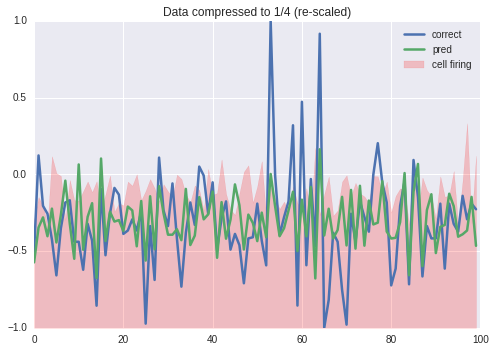

In [1153]:
ma = np.random.randint(0,len(all_val)-(in_size))
inp = norm_and_center(all_val[ma:ma+(in_size+1)])
v = Variable(cuda.to_gpu(np.array([inp.astype(np.float32)])))

ret = ae(v)




# x = np.array(zip(inp,cuda.to_cpu(ret.data)[0]))

# xx = map(lambda x: [x[0],x[1].tolist()], x)

# cova = np.cov(xx)
# # print(cova[0][1])
# print("(Higher is better)")
# print("Inv. covariance:  ",1/(np.sum(cova)/np.sum(np.shape(cova))))
# print("Inv. correlation: ",(1/np.correlate(inp,cuda.to_cpu(ret.data)[0]))[0])


links = []
for i in ae.namedlinks():
    if len(i[0])>1:
        links.append(i)
for link_name,link in sorted(links,key=lambda x: x[0]):
#     print(type(i))
#     print(link_name[1:], link.W.data.shape)
    v = link(v).data
    # YlOrRd, black is highest
    # YlGnBu, yellow highest
    # viridis, yellow highest
    to_plot = np.repeat(cuda.to_cpu(v)[0], 100/link.W.data.shape[0])
    sns.heatmap([to_plot], cmap="viridis", square=True,
            xticklabels=False,
            yticklabels=False,
           cbar=False)
    plt.show()
    v = Variable(cuda.to_gpu(v))
    
    
su = np.sum(cuda.to_cpu(ae.l0.W.data).T,axis=1)

plt.plot(inp,label="correct")
plt.plot(cuda.to_cpu(ret.data)[0],label="pred")
# plt.plot(su,alpha=0.5,fillstyle="bottom",label="ex")
plt.fill_between(range(100),center(su)/3,[-1]*100,color="r",alpha=0.2,zorder=1,label="cell firing")
plt.legend()
plt.title("Data compressed to 1/4 (re-scaled)")
plt.show()

In [1141]:
100/link.W.data.shape[0]

2

In [1144]:
ma = np.random.randint(0,len(all_val)-(in_size))
inp = norm_and_center(all_val[ma:ma+(in_size+1)])
v = Variable(cuda.to_gpu(np.array([inp.astype(np.float32)])))


links = []
for i in ae.namedlinks():
    if len(i[0])>1:
        links.append(i)
for link_name,link in sorted(links,key=lambda x: x[0]):
#     print(type(i))
#     print(link_name[1:], link.W.data.shape)
    v = link(v).data
    # YlOrRd, black is highest
    # YlGnBu, yellow highest
    # viridis, yellow highest
    to_plot = np.repeat(cuda.to_cpu(v)[0], 100/link.W.data.shape[0])
    sns.heatmap([to_plot], cmap="viridis", square=True,
            xticklabels=False,
            yticklabels=False,
           cbar=False)
    plt.show()
    v = Variable(cuda.to_gpu(v))

In [1083]:
len(ae.l0(v).data[0])

50

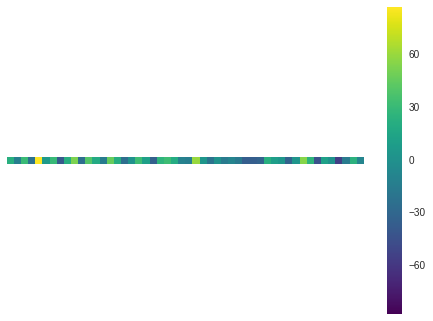

In [1125]:
su = np.sum(cuda.to_cpu(ae.l0.W.data).T,axis=1)
sns.heatmap([cuda.to_cpu(ae.l0(v).data)[0]],
            cmap="viridis",
            square=True,
            xticklabels=False,
            yticklabels=False,
)
# sns.heatmap([su]).set(xticks=[],yticks=[])
plt.show()

In [859]:
in_size = 1000
h_size = 250
h_size2 = 400
h_size3 = 700

out_size = in_size
class AutoEnc(chainer.Chain):
    def __init__(self):
        super(AutoEnc, self).__init__(
            l0 = L.Linear(in_size,h_size2),
            l2 = L.LSTM(h_size2,h_size),
            l3 = L.LSTM(h_size,h_size2),
            l5 = L.Linear(h_size2,out_size),
#             l0 = L.Linear(in_size,h_size3),
#             l1 = L.Linear(h_size3,h_size2),
#             l2 = L.LSTM(h_size2,h_size),
#             l3 = L.Linear(h_size,h_size2),
#             l4 = L.Linear(h_size2,h_size3),
#             l5 = L.Linear(h_size3,out_size),
        )
        
    def reset_state(self):
        self.l2.reset_state()
        self.l3.reset_state()
        
    def __call__(self, x):
        h = F.tanh(self.l0(x))
        h = F.tanh(self.l2(h))
        h = F.tanh(self.l3(h))
        h = F.tanh(self.l5(h))
#         h = F.tanh(self.l0(x))
#         h = F.tanh(self.l1(h))
#         h = F.tanh(self.l2(h))
#         h = F.tanh(self.l3(h))
#         h = F.tanh(self.l4(h))
#         h = F.tanh(self.l5(h))
        return h
    
class Train(chainer.Chain):
    def __init__(self, predictor):
        super(Train, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.mean_squared_error(y, t)
#         self.accuracy = F.accuracy(y, t)
        return self.loss

In [860]:
L.LSTM

chainer.links.connection.lstm.LSTM

In [862]:
ae = AutoEnc()
tae = Train(ae)
tae.to_gpu()
opti = optimizers.Adam()
opti.setup(tae)

In [863]:
ae.reset_state()

In [915]:
#%%time
n_epoch = 10000
batch_size = 100

ae.reset_state()


for epoch in range(n_epoch):
#     ba = []
#     for i in range(batch_size):
#         ma = np.random.randint(0,len(all_val)-(in_size+1))
#         inp = norm_and_center(all_val[ma:ma+in_size+1])   
#         ba.append(inp.astype(np.float32))

    ae.reset_state()

    ma = np.random.randint(0,len(all_val)-(in_size+1))
    inp = norm_and_center(all_val[ma:ma+in_size+1]) 
    ba = np.array([[i] for i in inp]).astype(np.float32).T
    
    v = Variable(cuda.to_gpu(np.array(ba)))
    
    opti.update(tae,v,v)
    if epoch==0 or epoch%(n_epoch/20)==0 or epoch==n_epoch-1:
        print("%s: %0.9f" %(str(epoch).ljust(10),tae.loss.data))

0         : 0.034014281
500       : 0.059305616
1000      : 0.017694764
1500      : 0.024822626
2000      : 0.055266380
2500      : 0.004791535
3000      : 0.019841157
3500      : 0.028654182
4000      : 0.027645271
4500      : 0.030106673
5000      : 0.030367998
5500      : 0.039066449
6000      : 0.030299069
6500      : 0.042325731
7000      : 0.036139227
7500      : 0.020557543
8000      : 0.031770591
8500      : 0.021898065
9000      : 0.002638343
9500      : 0.034405995
9999      : 0.038353320


In [926]:
ae.reset_state()
# ma = np.random.randint(0,len(all_val)-(in_size+1))
# inp = norm_and_center(all_val[ma:ma+(in_size+1)])
# v = Variable(cuda.to_gpu(np.array([inp.astype(np.float32)])))

ma = np.random.randint(0,len(all_val)-(in_size+1))
inp = norm_and_center(all_val[ma:ma+in_size+1]) 
ba = np.array([[i] for i in inp]).astype(np.float32).T

v = Variable(cuda.to_gpu(np.array(ba)))

ret = ae(v)

print(inp[-10:])
print(ret.data[0][-10:])

plt.plot(inp[-200:],label="correct")
plt.plot(cuda.to_cpu(ret.data)[0][-200:],label="pred")
plt.legend()
x = np.array(zip(inp,cuda.to_cpu(ret.data)[0]))

xx = map(lambda x: [x[0],x[1].tolist()], x)

cova = np.cov(xx)
# print(cova[0][1])
print("(Higher is better)")
print("Inv. covariance:  ",1/(np.sum(cova)/np.sum(np.shape(cova))))
print("Inv. correlation: ",(1/np.correlate(inp,cuda.to_cpu(ret.data)[0]))[0])

[-0.15666932 -0.15667267 -0.20088819 -0.06824835  0.02015255 -0.06826174
 -0.06826508  0.02010237 -0.20084134 -0.20085472]
[-0.11258598 -0.1085121  -0.12179309 -0.10832338 -0.13369234 -0.14219289
 -0.13632657 -0.1349892  -0.13737531 -0.14978775]
(Higher is better)
Inv. covariance:   38.0815700497
Inv. correlation:  0.0741957


In [349]:
sum_loss, sum_accuracy = 0, 0

for i in range(0, 1000, batch_size):
    ba=[]
    for i in range(batch_size):
        ma = np.random.randint(0,len(all_val)-(in_size+1))
        inp = norm_and_center(all_val[ma:ma+(in_size+1)])
        ba.append(inp.astype(np.float32))
    v = Variable(cuda.to_gpu(np.array(ba)))
    
    loss = tae(v, v)
    sum_loss += loss.data * batch_size
mean_loss = sum_loss / 1000
print(mean_loss)

0.0370470620692


In [8]:
from __future__ import print_function
def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

mp = load_json("/project/exp/list_mp.json")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

h5 = histdata.get_pandadb()
df = h5[histdata.get_table_name(mp['symbol'], mp['timeframe'])]

In [ ]:
#!cat /project/python/lib/ml/simsearch.py

In [9]:
%%time
# %%time
# %%timeit -n 20
# "201402041452","start":"201402041332
start, end = "2016-05-10 01:15:00" , "2016-05-10 04:55:00"
#start, end = "2015-04-02 09:00:00" , "2015-04-02 10:55:00"
ret = search(mp,start,end, samples=10000, k_nearest=5)

CPU times: user 40 ms, sys: 88 ms, total: 128 ms
Wall time: 292 ms


In [10]:
def norma(seq):
    return np.array(map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:])))

def norm_and_center(x,scale=1):
    c2 = norma(x)
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return np.array([[[i]] for i in c]).astype(np.float32)
#cc = norm_and_center(seq[11]["open"].values)

---

In [17]:
df[start:end]["open"].values

array([ 1.1393 ,  1.13912,  1.13902,  1.13896,  1.13862,  1.1384 ,
        1.13846,  1.13834,  1.13822,  1.13814,  1.13808,  1.138  ,
        1.13804,  1.13813,  1.13811,  1.13816,  1.13799,  1.13761,
        1.13739,  1.13729,  1.13769,  1.13788,  1.13787,  1.13776,
        1.13789,  1.13785,  1.1381 ,  1.13838,  1.13809,  1.13807,
        1.13804,  1.13771,  1.13759,  1.13795,  1.13814,  1.13818,
        1.13796,  1.13775,  1.13801,  1.13802,  1.13764,  1.13768,
        1.13767,  1.13751,  1.13744])

In [22]:
ddf = df[start:end]

In [14]:
ddf.head()

open     high      low    close
2015-01-09 00:00:00+00:00  1.17922  1.17938  1.17906  1.17926
2015-01-09 00:05:00+00:00  1.17924  1.17945  1.17924  1.17940
2015-01-09 00:10:00+00:00  1.17939  1.17942  1.17926  1.17933
2015-01-09 00:15:00+00:00  1.17933  1.17935  1.17924  1.17924
2015-01-09 00:20:00+00:00  1.17926  1.17926  1.17909  1.17911

In [103]:
def norma(seq):
    return map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:]))
def norm_and_center(x,scale=1):
    c2 = np.array(norma(x))
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return [i for i in c]

In [104]:
dd = ddf.apply(norm_and_center, axis=0, reduce=True,raw=True)
np.shape(dd)

(4,)

In [105]:
type(dd[0])

list

In [106]:
dd.apply(pd.Series).T.head()

open      high       low     close
0  0.142759  0.056373  0.348208  0.288967
1  0.338427 -0.084607  0.110934 -0.022438
2  0.022342 -0.141001  0.051617 -0.052103
3  0.007285 -0.169205 -0.141168 -0.111437
4 -0.098094  0.028185  0.096107  0.244505

In [35]:
np.shape(ddf)

(109, 4)

In [23]:
dd = pd.DataFrame(columns=["open"])
dd["open"] = norma(ddf["open"].values)
dd

open
0    0.000017
1    0.000127
2   -0.000051
3   -0.000059
4   -0.000119
5    0.000085
6   -0.000008
7    0.000170
8   -0.000076
9    0.000187
10  -0.000051
11   0.000119
12   0.000466
13   0.000237
14   0.000364
15  -0.000381
16   0.000186
17   0.000025
18   0.000144
19  -0.000076
20  -0.000017
21  -0.000254
22  -0.000161
23  -0.000093
24   0.000034
25   0.000068
26   0.000025
27   0.000364
28  -0.000042
29  -0.000254
..        ...
78  -0.000169
79  -0.000627
80   0.000051
81  -0.000364
82   0.000220
83  -0.000424
84   0.000254
85   0.000161
86  -0.000017
87   0.000059
88  -0.000203
89  -0.000517
90   0.000076
91  -0.000085
92  -0.000331
93   0.000093
94   0.000178
95   0.000407
96   0.000305
97   0.000500
98   0.000178
99  -0.000068
100  0.000161
101 -0.000076
102 -0.000025
103 -0.000212
104  0.000059
105  0.000025
106  0.000119
107  0.000051

[108 rows x 1 columns]

In [8]:
#%%time
start, end = "2015-01-9 00:00:00+0000" , "2015-01-9 09:00:00+0000"
#start, end = "2015-04-02 09:00:00" , "2015-04-02 10:55:00"  2015-01-10 00:00:00+0000
ret = search(mp,start,end, samples=10000, k_nearest=5)

QUERY


SUGGESTIONS


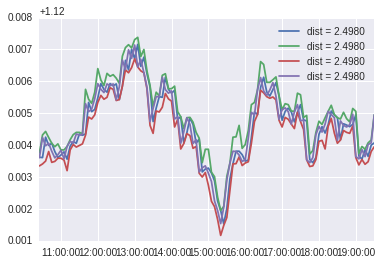

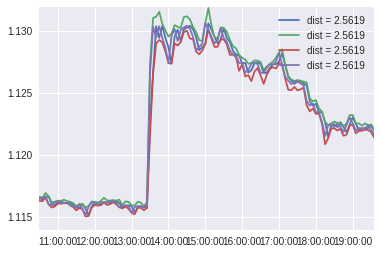

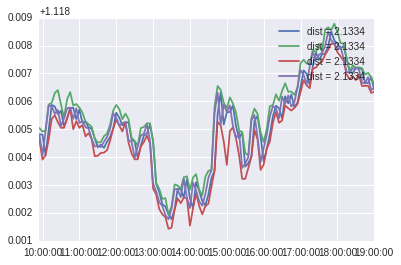

In [9]:
print("QUERY")
plt.plot(df[start:end],label="query")
plt.legend()
plt.show()
print("SUGGESTIONS")
for n in range(len(ret)):
    plt.plot(df[ret[n]["start"]:ret[n]["end"]],label="dist = %.04f"%(ret[n]["distance"]))
    plt.legend()
    plt.show()
    
# print("*"*80)
